Solving the radiative transfer equation for a single atmospheric layer using the discrete ordinates method in Python

by Dion Ho Jia Xu

In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from inspect import signature
from math import pi
from numpy.polynomial import legendre
from scipy import integrate

# Table of Contents
* [1. USER INPUT REQUIRED: List of parameters to set](#1.-USER-INPUT-REQUIRED:-List-of-parameters-to-set)
	* [1.1 Hyperparameter list (excludes phase function)](#1.1-Hyperparameter-list-%28excludes-phase-function%29)
	* [1.2 Computational variable list](#1.2-Computational-variable-list)
	* [1.3 Legendre expansion of the phase function](#1.3-Legendre-expansion-of-the-phase-function)
		* [1.3.1 Phase functions](#1.3.1-Phase-functions)
		* [1.3.2 $\delta-M$ scaled Legendre coefficients](#1.3.2-$\delta-M$-scaled-Legendre-coefficients)
* [2. PyDISORT algorithm](#2.-PyDISORT-algorithm)
	* [2.1 Subroutines](#2.1-Subroutines)
	* [2.2 Main algorithms (TODO)](#2.2-Main-algorithms-%28TODO%29)
		* [2.2.1 Call PyDISORT (TODO)](#2.2.1-Call-PyDISORT-%28TODO%29)
* [3. Breakdown and verification of single layer solver](#3.-Breakdown-and-verification-of-single-layer-solver)
	* [3.1 Quadrature](#3.1-Quadrature)
		* [3.1.1 Verification of quadrature weights and points on test integral](#3.1.1-Verification-of-quadrature-weights-and-points-on-test-integral)
		* [3.1.2 Normalization verification of the phase function](#3.1.2-Normalization-verification-of-the-phase-function)
	* [3.2 Re-derivation of equations (6a) to (6d) in Stamnes et. al., 1988](#3.2-Re-derivation-of-equations-%286a%29-to-%286d%29-in-Stamnes-et.-al.,-1988)
	* [3.3 $\delta-M$ scaling in the Radiative Transfer Equation](#3.3-$\delta-M$-scaling-in-the-Radiative-Transfer-Equation)
	* [3.4 Re-derivation of equations (7a) and (7b) in Stamnes et. al., 1988](#3.4-Re-derivation-of-equations-%287a%29-and-%287b%29-in-Stamnes-et.-al.,-1988)
	* [3.5 Solving the system for each Fourier mode](#3.5-Solving-the-system-for-each-Fourier-mode)
	* [3.6 Constructing the general solution for each Fourier mode](#3.6-Constructing-the-general-solution-for-each-Fourier-mode)
		* [3.6.1 The particular solution](#3.6.1-The-particular-solution)
		* [3.6.2 The homogeneous solution](#3.6.2-The-homogeneous-solution)
		* [3.6.3 Verification of the general solution for one Fourier mode](#3.6.3-Verification-of-the-general-solution-for-one-Fourier-mode)
	* [3.7 The full solution](#3.7-The-full-solution)
		* [3.7.1 Verification of full solution](#3.7.1-Verification-of-full-solution)
		* [3.7.2 Nakajima-Tanaka (NT) corrections (TODO)](#3.7.2-Nakajima-Tanaka-%28NT%29-corrections-%28TODO%29)
		* [3.7.3 Verification of NT corrected full solution](#3.7.3-Verification-of-NT-corrected-full-solution)
		* [3.7.4 Computation of flux](#3.7.4-Computation-of-flux)
			* [3.7.4.1 Verification of flux](#3.7.4.1-Verification-of-flux)
			* [3.7.4.2 Computation of reflectivity and transmittivity](#3.7.4.2-Computation-of-reflectivity-and-transmittivity)
		* [3.7.5 Timing PyDISORT](#3.7.5-Timing-PyDISORT)
* [4. Solving for multiple atmospheric layers (TODO)](#4.-Solving-for-multiple-atmospheric-layers-%28TODO%29)
* [5. Comparisons with Stamnes' DISORT (TODO)](#5.-Comparisons-with-Stamnes'-DISORT-%28TODO%29)


We wish to solve the radiative transfer equation

\begin{aligned}
\mu \frac{\partial u(\tau, \mu, \phi)}{\partial \tau} = u(\tau, \mu, \phi) &-\frac{\omega_0}{4 \pi} \int_{-1}^{1} \int_{0}^{2 \pi} p\left(\mu, \phi ; \mu', \phi'\right) u\left(\tau, \mu', \phi'\right) \mathrm{d} \phi' \mathrm{d} \mu' \\
&-\frac{\omega_0 I_0}{4 \pi} p\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right) \exp\left(-\mu_{0}^{-1} \tau\right)
\end{aligned}

with Dirichlet boundary conditions for the **diffuse** intensity, $u = u_\text{diffuse}$. This will be done numerically using the Discrete Ordinates Method. The total intensity is given by

$$u_\text{total} = u_\text{diffuse} + u_\text{direct}$$

where 

$$u_\text{direct}(\tau, \mu, \phi) = I_0 \delta(\mu - \mu_0) \delta(\phi - \phi_0) \exp\left(-\mu_{0}^{-1} \tau\right)$$

**IMPORTANT:** Note that `PyDISORT` will output the **diffuse intensity** and the **total flux**. One will need to separately add the intensity of the direct beam to get the total intensity.

# 1. USER INPUT REQUIRED: List of parameters to set

For many parameters, it is possible to adjust the code to accomodate a wider range of values. Doing that, however, would slow-down and convolute the code. These special cases should also rarely arise in physical models.

## 1.1 Hyperparameter list (excludes phase function)

The variable names generally follow those in Stamnes et. al.'s 1988 paper [[1]](#cite-STWJ1988), with the equivalent variable in their FORTRAN DISORT code [[2]](#cite-Sta1999) in brackets.

* Optical depth (DTAUC), i.e. bottom of atmosphere as we define the top to be $\tau = 0$. We implemented Stamnes-Conklin's substitutions [[3]](#cite-SC1984) to accomodate large `tau0` values. Nonetheless, since `tau0` will be exponentiated, large `tau0` values will still cause inaccuracies.

In [2]:
tau0 = 100

* Single-scattering albedo (SSALB). We assume independence from $\tau$.

In [3]:
w0 = 0.2

The permissible range of values is $[0,1)$, values too close to $1$ will cause instability.

In [4]:
assert w0 >= 0
assert w0 < 1

* Parameters for the incident collimated beam. The flux contribution of this beam is $I_0 \mu_0$. Note that we do not allow $\mu_0$ to equal a quadrature / computational angle and `PyDISORT` will check for this; this is consistent with Stamnes' DISORT [[1]](#cite-STWJ1988).

In [5]:
# Intensity (FBEAM)
I0 = 10 * pi
# Cosine of polar angle (UMU0)
mu0 = pi / 4
# Azimuthal angle (PHI0)
phi0 = pi / 3

We do not allow `mu0` to be less than or equal to $0$; `PyDISORT` is not designed to model a beam shining up from the surface into the bottom of the atmosphere. Small `mu0` values will cause instability. We also require both angles to be principal.

In [6]:
assert 0 < mu0 and mu0 < 1
assert 0 < phi0 and phi0 < 2 * pi

 * Dirichlet boundary conditions (No direct equivalent in Stamnes' DISORT [[2]](#cite-Sta1999), but see variable *IBCND*)

$$
u\left(\tau_0, \mu_i, \phi \right) = \sum_{m = 0}^{\text{NLeg}}b^+_{im}\cos(m(\phi_0 - \phi)), \quad u(0, -\mu_i, \phi) = \sum_{m = 0}^{\text{NLeg}}b^-_{im}\cos(m(\phi_0 - \phi)) \quad i = 1, \dots, N
$$

where $b^\pm$ are to be specified, and variables `NLeg` and $N$ are specified further down.

In [7]:
# These should actually be matrices with row index i and column index m,
# but it is ok for them to be a constant.
# Do NOT input a vector,
# while we can implement code to accomodate vector inputs it would be unnecessarily confusing.

# At bottom of atmosphere
b_pos = 0

# At top of atmosphere
b_neg = 0

* Whether to only compute flux values (ONLYFL). If `True`, `PyDISORT` will be much faster because we will only need to solve the $0$th Fourier mode integro-differential equation, see sections [3.7.3](#3.7.4-Computation-of-flux)

In [8]:
only_flux = False

## 1.2 Computational variable list

* Number of Legendre coefficients for the phase function (NMOM). Equal to the number of Fourier modes.

In [9]:
NLeg = 8

* Number of evaluation points for quadrature approximation of the polar or $\mu$ integral (NSTR). This parameter is also known as the number of "streams".

In [10]:
NQuad = 8

`NQuad` is required to be greater than $2$, even, and less than or equal to `NLeg`. It is generally a good idea to have `NQuad == NLeg`.

In [11]:
assert NQuad > 2
assert NQuad % 2 == 0
assert NQuad <= NLeg

We define $N = \text{NQuad} \ / \ 2$. This variable will be used extensively later on.

In [12]:
N = NQuad // 2

Each BC input must be a scalar or a matrix of dimension $N \times \text{NLeg}$

In [13]:
# This ensures that the BC inputs are of the correct shape
if len(np.atleast_1d(b_pos)) == 1:
    b_pos = np.full((N, NLeg), b_pos)
else:
    assert np.shape(b_pos) == (N, NLeg)
if len(np.atleast_1d(b_neg)) == 1:
    b_neg = np.full((N, NLeg), b_pos)
else:
    assert np.shape(b_neg) == (N, NLeg)

## 1.3 Legendre expansion of the phase function

We assume that the phase function is only directly dependent on the scattering angle $\gamma$, i.e. the scattering medium has spherical symmetry. Following the method in [[1]](#cite-STWJ1988) but with slightly different notations and definitions, we expand the phase function

$$
p(\cos\gamma) \approx \sum_{\ell=0} g_\ell P_\ell(\cos\gamma), \quad g_\ell = \frac{2\ell + 1}{2}\int_{-1}^{1} p(\cos\gamma) P_\ell(\cos\gamma) \mathrm{d}\cos\gamma
$$

The scattering angle $\gamma$ is between the incident vector $\left(\theta', \phi'\right)$ and the scattering vector $(\theta, \phi)$ such that

$$
\begin{aligned}
\cos\gamma &= \cos\theta'\cos\theta + \sin\theta'\sin\theta\cos\left(\phi'-\phi\right) \\
\iff \nu &= \mu' \mu + \sqrt{1 - \mu'^2} \sqrt{1 - \mu^2} \cos\left(\phi'-\phi\right)
\end{aligned}
$$

where we define

$$
\nu = \cos\gamma, \quad \mu = \cos\theta, \quad\mu' = \cos\theta'
$$

Therefore, by the addition theorem for spherical harmonics

$$
P_\ell(\cos\gamma) = P_\ell\left(\cos\theta'\right)P_\ell(\cos\theta) + 2\sum_{m=1}^\ell \frac{(\ell-m)!}{(\ell+m)!}P_\ell^m\left(\cos\theta'\right)P_\ell^m(\cos\theta)\cos\left(m\left(\phi'-\phi\right)\right)
$$

### 1.3.1 Phase functions

Phase functions in Stamnes' DISORT [[2]](#cite-Sta1999):
* Isotropic
* Rayleigh
* Henyey-Greenstein with asymmetry factor
* Haze L as specified by Garcia/Siewert
* Cloud C.1 as specified by Garcia/Siewert
* Aerosol as specified by Kokhanovsky 
* Cloud as specified by Kokhanovsky

In general, we will use the $\nu$-argument form of a phase function as it is the most straightforward to integrate. In our exposition, however, we will generally express a phase function with arguments $\mu, \phi, \mu', \phi'$ for consistency with the radiative transfer equation.

**Henyey-Greenstein phase function**

The exact definition varies between sources by a constant factor. The definition here follows [[1]](#cite-STWJ1988), though the phase function is not explicitly defined in that paper:

$$\frac{1-g^2}{\left(1+g^2-2 g \nu\right)^{3 / 2}}$$

* Asymmetry factor (GG)

In [14]:
g = 0.75

* Phase function

In [15]:
p_HG_nu = lambda nu, g: (1 - g**2) / ((1 + g**2 - 2 * g * nu) ** (3 / 2))

* **Weighted** array of $g_\ell$ values $\big((2\ell + 1) \times \text{PMOM}\big)$

In [16]:
m_arr = np.arange(NLeg)
Leg_coeffs = (2 * m_arr + 1) * g**m_arr

* A tuple containing the true phase function with vector argument $\nu$ and asymmetry factor $g$. These need to be supplied to `PyDISORT` for Nakajima-Tanaka corrections, see section [3.7.1](#3.7.2-Nakajima-Tanaka-%28NT%29-corrections-Main-algorithms-Call-PyDISORT-Nakajima-Tanaka-%28NT%29-corrections-Solving-for-multiple-atmospheric-layers-Comparisons-with-Stamnes'-DISORT-2.2-Main-algorithms-2.2.1-Call-PyDISORT-3.7.2-Nakajima-Tanaka-%28NT%29-corrections-4.-Solving-for-multiple-atmospheric-layers-5.-Comparisons-with-Stamnes'-DISORT-Main-algorithms-Call-PyDISORT-Nakajima-Tanaka-%28NT%29-corrections-Solving-for-multiple-atmospheric-layers-Comparisons-with-Stamnes'-DISORT-2.2-Main-algorithms-2.2.1-Call-PyDISORT-3.7.2-Nakajima-Tanaka-%28NT%29-corrections-4.-Solving-for-multiple-atmospheric-layers-5.-Comparisons-with-Stamnes'-DISORT-%28TODO%29).

In [17]:
p_for_NT_with_g = (p_HG_nu, g)

In [18]:
# Explained in section 3.7.1
assert len(signature(p_for_NT_with_g[0]).parameters) == 2

**Integral derivation of Legendre coefficients for verification**

[Skip verification](#1.3.2-$\delta-M$-scaled-Legendre-coefficients)

This algorithm can be used to derive the Legendre coefficients for other phase functions. The algorithm can also be vectorized, but we would no longer be able to use `scipy.integrate.quad` for integration.

In [19]:
Leg_coeffs_test = np.empty(NLeg)
for ell in range(NLeg):
    integrand = lambda nu: p_HG_nu(nu, g) * sc.special.eval_legendre(ell, nu)
    Leg_coeffs_test[ell] = ((2 * ell + 1) / 2) * integrate.quad(integrand, -1, 1)[0]

assert np.allclose(Leg_coeffs, Leg_coeffs_test)

print("Passed all tests")

Passed all tests


### 1.3.2 $\delta-M$ scaled Legendre coefficients

Standard Legendre series approximation of highly anisotropic phase functions require a large number of terms to accurately capture their strong directional scattering. The Henyey-Greenstein phase function, for example, is strongly forward scattering. We can use fewer Legendre terms if we re-express the phase function as a linear combination of a $\delta$-function and an (approximately) isotropic remainder. We follow the method in [[5]](#cite-Wis1977) for scaling the first $2M$ Legendre coefficients of a phase function such that they become the coefficients of the isotropic remainder.

\begin{aligned}
&p(\cos \gamma) \approx 2 f \delta(1-\cos \gamma) + (1 - f) \sum_{\ell=0}^{2 M-1} (2 \ell+1) g_\ell^* P_\ell(\cos \gamma), \quad g^*_\ell = \frac{g_\ell - f}{1 - f} \\
&\iff p(\mu, \phi; \mu', \phi') \approx 4 \pi f \delta(\mu - \mu')\delta(\phi - \phi') + (1 - f) p^*(\mu, \phi; \mu', \phi')
\end{aligned}

where $\mu = \cos\theta$, $\mu' = \cos\theta'$, and the fractional scattering into the forward peak $f \in [0, 1)$ is to be chosen with $f = 0$ equivalent to no $\delta-M$ scaling. The first $2M$ Legendre coefficients of this re-expression will agree with those of the phase function.

We generally choose $f = g_{2M} = g_\text{NLeg}$ so that the scaled Legendre series is equivalent to the standard Legendre series in the limit $M \rightarrow \infty$. An implication of this is that $\delta-M$ scaling is unimpactful for large $M$, which is desirable. This choice of $f$ with $M = 1$ is equivalent to the delta-Eddington method, see [[6]](#cite-JWW1976). We discuss the impact of this phase function re-expression on the radiative transfer equation in section [2.3.2](#3.3-$\delta-M$-scaling-in-the-Radiative-Transfer-Equation).

The flag to enable $\delta-M$ scaling is `f > 0`.

In [20]:
# The RHS is an UNWEIGHTED Legendre coefficient
f = g**NLeg

In [21]:
assert 0 <= f and f < 1

# 2. PyDISORT algorithm

[Skip section](#3.-Breakdown-and-verification-of-single-layer-solver)

## 2.1 Subroutines

In [22]:
def transform_interval(arr, c, d, a=-1, b=1):
    """Transforms a vector in interval [a, b] to a similar vector in [c, d]
    
    :Input:
     - *arr* (vector) - The vector to transform
     - *c* (float) - The beginning of interval [c, d]
     - *d* (float) - The end of interval [c, d]
     :Optional:
     - *a* (float) - The beginning of interval [a, b]
     - *b* (float) - The end of interval [a, b]
     
    :Output:
     - (vector) - The transformed vector 
    """
    return (((arr - a) * (d - c)) / (b - a)) + c

In [23]:
def transform_weights(weights, c, d, a=-1, b=1):
    """Transform quadrature weights in interval [a, b] to similar weights in [c, d]
    
    :Input:
     - *weights* (vector) - The weights to transform
     - *c* (float) - The beginning of interval [c, d]
     - *d* (float) - The end of interval [c, d]
     :Optional:
     - *a* (float) - The beginning of interval [a, b]
     - *b* (float) - The end of interval [a, b]
     
    :Output:
     - *weights* (vector) - The transformed weights 
    """
    return weights * (d - c) / (b - a)

In [24]:
def calculate_nu(mu, phi, mu_p, phi_p):
    """Calculates the scattering angle nu between incident angle (mu_p, phi_p) and scattering angle (mu, phi)
    
    :Input:
     - *mu* (vector / float) - The weights to transform
     - *phi* (vector / float) - The beginning of interval [c, d]
     - *mu_p* (vector / float) - The end of interval [c, d]
     - *phi_p* (vector / float) - The beginning of interval [c, d]
     
    :Output:
     - *nu* (tensor / float) - The transformed weights 
    """
    mu, phi, mu_p, phi_p = np.atleast_1d(mu, phi, mu_p, phi_p)
    nu = mu_p[None, None, :, None] * mu[:, None, None, None] + np.sqrt(1 - mu_p**2)[
        None, None, :, None
    ] * np.sqrt(1 - mu**2)[:, None, None, None] * np.cos(
        phi_p[None, None, None, :] - phi[None, :, None, None]
    )
    return np.squeeze(nu)

In [25]:
def generate_Ds(m):
    """Generates the D term in the system of ODEs for each Fourier mode, see Section 3.2
    
    :Input:
     - *m* (int) - The Fourier mode
     
    :Output:
     - *D_pos* (matrix) - D with only elements that correspond to positive mu values
     - *D_neg* (matrix) - D with only elements that correspond to negative mu values
    """
    ells = np.arange(m, NLeg)
    Dm_term = Leg_coeffs[ells] * (
        sc.special.factorial(ells - m) / sc.special.factorial(ells + m)
    )

    degree_tile = np.tile(ells, (N, 1)).T
    asso_leg_term_pos = sc.special.lpmv(m, degree_tile, mu_arr_pos)
    asso_leg_term_neg = sc.special.lpmv(m, degree_tile, -mu_arr_pos)
    D_temp = (Dm_term)[None, :] * asso_leg_term_pos.T

    D_pos = (w0 / 2) * D_temp @ asso_leg_term_pos
    D_neg = (w0 / 2) * D_temp @ asso_leg_term_neg

    return D_pos, D_neg

In [26]:
# Generate the X term in the system of ODEs
def generate_Xs(m):
    """Generates the X term in the system of ODEs, see Section 3.2
    
    :Input:
     - *m* (int) - The Fourier mode
     
    :Output:
     - *X_pos* (vector) - X with only elements that correspond to positive mu values
     - *X_neg* (vector) - X with only elements that correspond to negative mu values
    """
    if m == 0:
        prefactor = w0 * I0 / (4 * pi)
    else:
        prefactor = w0 * I0 / (2 * pi)

    ells = np.arange(m, NLeg)
    Xm_term = Leg_coeffs[ells] * (
        sc.special.factorial(ells - m) / sc.special.factorial(ells + m)
    )
    Xm_term2 = sc.special.lpmv(m, ells, -mu0)
    X_temp = prefactor * Xm_term * Xm_term2

    degree_tile = np.tile(ells, (N, 1)).T
    X_pos = X_temp @ sc.special.lpmv(m, degree_tile, mu_arr_pos)
    X_neg = X_temp @ sc.special.lpmv(m, degree_tile, -mu_arr_pos)

    return X_pos, X_neg

In [27]:
# Create the up and down flux functions
def generate_flux_functions(
    """Generates the flux functions with respect to the radiative transfer equation
    
    :Input:
     - *I0* (float) - Intensity of the direct beam
     - *mu0* (float) - Polar angle of the direct beam
     - *GC_pos / neg* (matrix) - Product of eigenvectors and coefficients that correspond to positive / negative mu values
     - *eigenvals* (vector) - Eigenvalues
     - *B_pos / neg* (vector) - Coefficients of the inhomogenity that correspond to positive / negative mu values
     - *mu_arr_pos / neg* (vector) - Positive / negative mu values
     - *scale_tau* (float) - Delta-M scale factor for tau
     - *scale_beam* (float) - Delta-M scale factor for the direct beam
     
     
    :Output:
     - *flux_up* (function) - Flux function with argument tau for positive (upward) mu values
     - *flux_down* (vector) - Flux function with argument tau for negative (downward) mu values
    """
    I0, mu0, 
    GC_pos, GC_neg, 
    eigenvals, 
    B_pos, B_neg, 
    mu_arr_pos, weights_mu, 
    scale_tau, scale_beam,
):
    def flux_up(tau):
        tau = scale_tau * np.atleast_1d(tau) # Delta-M scaling
        exponent = np.vstack(
            (
                eigenvals[:N, None] * (tau - tau0)[None, :],
                eigenvals[N:, None] * tau[None, :],
            )
        )
        um = GC_pos @ np.exp(exponent) + B_pos[:, None] * np.exp(-tau[None, :] / mu0)
        return np.squeeze(2 * pi * (mu_arr_pos * weights_mu) @ um)

    def flux_down(tau):
        tau = scale_tau * np.atleast_1d(tau) # Delta-M scaling
        exponent = np.vstack(
            (
                eigenvals[:N, None] * (tau - tau0)[None, :],
                eigenvals[N:, None] * tau[None, :],
            )
        )
        um = GC_neg @ np.exp(exponent) + B_neg[:, None] * np.exp(-tau[None, :] / mu0)
        return np.squeeze(
            2 * pi * (mu_arr_pos * weights_mu) @ um
            + scale_beam * I0 * mu0 * np.exp(-tau / mu0)
        )

    return flux_up, flux_down

## 2.2 Main algorithms (TODO)

*TODO: Implement solver for multiple atmospheric layers as well as multi-layer scaling from [[3]](#cite-SC1984)*

In [28]:
def main(
    b_pos, b_neg,
    only_flux,
    N, NQuad, NLeg,
    mu_arr_pos, weights_mu,
    tau0, w0, Leg_coeffs,
    mu0, phi0, I0, 
    scale_tau, scale_beam,
):  # This function has many redundant arguments to maximize precomputation in the wrapper function
    
    """Basic radiative transfer solver which performs no corrections
    
    :Input:
     - *b_pos / neg* (matrix) - Boundary conditions for the upward / downward directions\
     - *only_flux* (boolean) - Flag for whether to compute the intensity function
     - *N* (int) - NQuad // 2
     - *NQuad* (int) - Number of mu quadrature points
     - *NLeg* (int) - Number of phase function Legendre coefficients to use in the basic solver
     - *mu_arr_pos* (vector) - Positive mu values
     - *weights_mu* (vector) - Weights for mu quadrature
     - *tau0* (float) - Optical depth
     - *w0* (float) - Single-scattering albedo
     - *mu0* (float) - Polar angle of the direct beam
     - *phi0* (float) - Azimuthal angle of the direct beam
     - *I0* (float) - Intensity of the direct beamz
     - *scale_tau* (float) - Delta-M scale factor for tau
     - *scale_beam* (float) - Delta-M scale factor for the direct beam
     
     
    :Output:
     - *flux_up* (function) - Flux function with argument tau for positive (upward) mu values
     - *flux_down* (vector) - Flux function with argument tau for negative (downward) mu values
     :Optional:
     - *u* (function) - Intensity function with arguments (tau, phi); the output is in the order (mu, tau, phi)
    """
    
    # If we want to solve for the intensity we need to solve for NLeg Fourier modes
    # If we only want to solve for the flux we only need to solve for the 0th Fourier mode
    if not only_flux:
        GC_collect = np.empty((NQuad, NLeg, NQuad))
        eigenvals_collect = np.empty((NQuad, NLeg))
        B_collect = np.empty((NQuad, NLeg))

    for m in range(NLeg):
        D_pos, D_neg = generate_Ds(m)
        M_inv = 1 / mu_arr_pos
        W = weights_mu[None, :]
        alpha = M_inv[:, None] * (D_pos * W - np.eye(N))
        beta = M_inv[:, None] * D_neg * W
        A = np.vstack((np.hstack((-alpha, -beta)), np.hstack((beta, alpha))))

        eigenvals_squared, eigenvecs_GpG = np.linalg.eig(
            (alpha - beta) @ (alpha + beta)
        )
        # Eigenvalues arranged from positive to negative, from largest to smallest absolute value
        eigenvals = np.concatenate((np.sqrt(eigenvals_squared), -np.sqrt(eigenvals_squared)))
        eigenvecs_GpG = np.hstack((eigenvecs_GpG, eigenvecs_GpG))
        eigenvecs_GmG = (alpha + beta) @ eigenvecs_GpG / -eigenvals

        G_pos = (eigenvecs_GpG + eigenvecs_GmG) / 2
        G_neg = (eigenvecs_GpG - eigenvecs_GmG) / 2
        G = np.vstack((G_pos, G_neg))

        X_pos, X_neg = generate_Xs(m)
        X_tilde = np.concatenate((-M_inv * X_pos, M_inv * X_neg))

        B = np.linalg.solve(-(np.eye(NQuad) / mu0 + A), X_tilde)
        B_pos, B_neg = B[:N], B[N:]
        K_tau0_neg = np.exp(eigenvals[N:] * tau0)
        
        LHS = G.copy()
        LHS[:N, N:] *= K_tau0_neg[None, :]
        LHS[N:, :N] *= K_tau0_neg[None, :]
        RHS = np.concatenate((b_pos[:, m] - B_pos * np.exp(-tau0 / mu0), b_neg[:, m] - B_neg))
        C = np.linalg.solve(LHS, RHS)

        if only_flux:
            return generate_flux_functions(
                I0, mu0,
                G_pos * C[None, :], G_neg * C[None, :],
                eigenvals,
                B_pos, B_neg,
                mu_arr_pos, weights_mu,
                scale_tau, scale_beam,
            )
        
        GC_collect[:, m, :] = G * C[None, :]
        eigenvals_collect[:, m] = eigenvals
        B_collect[:, m] = B

        def u(tau, phi):
            tau = scale_tau * np.atleast_1d(tau) # Delta-M scaling
            phi = np.atleast_1d(phi)
            exponent = np.concatenate(
                (
                    eigenvals_collect[:N, :, None] * (tau - tau0)[None, None, :],
                    eigenvals_collect[N:, :, None] * tau[None, None, :],
                ),
                axis=0,
            )
            um = np.einsum(
                "imj, jmt -> imt", GC_collect, np.exp(exponent), optimize=True
            ) + B_collect[:, :, None] * np.exp(-tau[None, None, :] / mu0)
            return np.squeeze(
                np.einsum(
                    "imt, mp -> itp",
                    um,
                    np.cos(np.arange(NLeg)[:, None] * (phi0 - phi)[None, :]),
                    optimize=True,
                )
            )

    return (u, ) + generate_flux_functions(
        I0, mu0,
        GC_collect[:N, 0, :], GC_collect[N:, 0, :],
        eigenvals_collect[:, 0],
        B_collect[:N, 0], B_collect[N:, 0],
        mu_arr_pos, weights_mu,
        scale_tau, scale_beam,
    )

### 2.2.1 Call PyDISORT (TODO)

*TODO: Implement IMS intensity correction. In the process, we likely need to swap from the use of the full true phase function to just a long approximating series -- remove `p_for_NT_with_g`, make `Leg_coeffs` long, and add an `NLeg` argument to decide the truncation. Also, add an assertion to force `Leg_coeffs` to be long enough such that the last elements in the list are sufficiently small?*

In [29]:
def PyDISORT(
    b_pos, b_neg, only_flux, NQuad, tau0, w0, Leg_coeffs, mu0, phi0, I0, f=0, p_for_NT_with_g=(None,),
):  # The argument order approximately follows that of Stamnes' DISORT
    """Full radiative transfer solver which performs corrections
    
    :Input:
     - *b_pos / neg* (matrix) - Boundary conditions for the upward / downward directions
     - *only_flux* (boolean) - Flag for whether to compute the intensity function
     - *NQuad* (int) - Number of mu quadrature points
     - *tau0* (float) - Optical depth
     - *w0* (float) - Single-scattering albedo
     - *Leg_coeffs* (vector) - Weighted Legendre coefficients of the phase function
     - *NLeg* (int) - Number of phase function Legendre coefficients to use in the basic solver
     - *mu0* (float) - Polar angle of the direct beam
     - *phi0* (float) - Azimuthal angle of the direct beam
     - *I0* (float) - Intensity of the direct beam
     :Optional:
     - f (float) - fractional scattering into the forward peak for use in delta-M scaling
     
     
     
    :Output:
     - *mu_arr* (vector) - All mu values
     - *flux_up* (function) - Flux function with argument tau for positive (upward) mu values
     - *flux_down* (vector) - Flux function with argument tau for negative (downward) mu values
     :Optional:
     - *u* (function) - Intensity function with arguments (tau, phi); the output is in the order (mu, tau, phi)
    """

    # INPUT CHECKS
    # -----------------------------------------------------------
    NLeg = len(Leg_coeffs)
    # The scattering fraction must be greater than or equal to 0 and less than 1
    assert 0 <= f and f < 1
    # We require principal angles and a downward beam
    assert 0 < mu0 and mu0 < 1
    assert 0 < phi0 and phi0 < 2 * pi
    # We require NQuad to be >2, even, and <= NLeg
    assert NQuad > 2
    assert NQuad % 2 == 0
    assert NQuad <= NLeg

    N = NQuad // 2
    # The following ensures that the BC inputs are of the correct shape
    if len(np.atleast_1d(b_pos)) == 1:
        b_pos = np.full((N, NLeg), b_pos)
    else:
        assert np.shape(b_pos) == (N, NLeg)
    if len(np.atleast_1d(b_neg)) == 1:
        b_neg = np.full((N, NLeg), b_neg)
    else:
        assert np.shape(b_neg) == (N, NLeg)
    # -----------------------------------------------------------

    # For positive mu values (the weights are identical for both domains)
    mu_arr_pos, weights_mu = legendre.leggauss(N)
    mu_arr_pos = transform_interval(mu_arr_pos, 0, 1)  # mu_arr_neg = -mu_arr_pos
    weights_mu = transform_weights(weights_mu, 0, 1)
    # We do not allow mu0 to equal a quadrature / computational angle
    assert not np.any(np.isclose(mu_arr_pos, mu0))

    # Delta-M scaling; there is no scaling if f == 0
    scale_tau = 1 - w0 * f
    scale_beam = 1 + w0 * f
    Leg_coeffs = (Leg_coeffs - f) / (1 - f)
    w0 *= (1 - f) / scale_tau
    tau0 *= scale_tau

    # Perform NT correction on the intensity but not the flux
    if callable(p_for_NT_with_g[0]) and not only_flux:
        assert len(signature(p_for_NT_with_g[0]).parameters) == 2
        p_for_NT = p_for_NT_with_g[0]
        g = p_for_NT_with_g[1]
        # We check that the last Legendre coefficient in Leg_coeffs matches the inputed phase function (TO CHANGE)
        assert np.isclose(
            ((2 * (NLeg - 1) + 1) / 2)
            * integrate.quad(
                lambda nu: p_for_NT(nu, g) * sc.special.eval_legendre(NLeg - 1, nu), -1, 1
            )[0],
            Leg_coeffs[NLeg - 1] * (1 - f) + f,
        )
        
        # Delta-M scaled solution
        u_star, flux_up, flux_down = main(
            b_pos, b_neg,
            False,
            N, NQuad, NLeg,
            mu_arr_pos, weights_mu,
            tau0, w0, Leg_coeffs,
            mu0, phi0, I0, 
            scale_tau, scale_beam,
        )

        # NT correction for the intensity
        def p_for_NT_muphi(mu, phi, mu_p, phi_p, g):
            nu = calculate_nu(mu, phi, mu_p, phi_p)
            return p_for_NT(nu, g)

        def tilde_u_star1(tau, phi):
            tau = scale_tau * np.atleast_1d(tau)
            tilde_mathcal_B = lambda tau, mu_arr, phi: (
                ((w0 * I0) / (4 * np.pi * (1 - f)))
                * np.exp(-tau / mu0)[None, :, None]
                * p_for_NT_muphi(mu_arr, phi, -mu0, phi0, g)[:, None, :]
                / (mu_arr / mu0 + 1)[:, None, None]
            )
            tilde_u_star1_pos = (
                tilde_mathcal_B(tau, mu_arr_pos, phi)
                * (
                    np.exp(-tau / mu0)[None, :]
                    - np.exp((tau - tau0)[None, :] * (1 / mu_arr_pos)[:, None] - tau0 / mu0)
                )[:, :, None]
            )
            tilde_u_star1_neg = (
                tilde_mathcal_B(tau, -mu_arr_pos, phi)
                * (
                    np.exp(-tau / mu0)[None, :]
                    - np.exp(tau[None, :] * (-1 / mu_arr_pos)[:, None])
                )[:, :, None]
            )
            return np.squeeze(np.concatenate((tilde_u_star1_pos, tilde_u_star1_neg), axis=0))

        def p_truncated(mu, phi, mu_p, phi_p):
            nu = calculate_nu(mu, phi, mu_p, phi_p)
            return legendre.Legendre(Leg_coeffs)(nu)

        def u_star1(tau, phi):
            tau = scale_tau * np.atleast_1d(tau)
            mathcal_B = lambda tau, mu_arr, phi: (
                ((w0 * I0) / (4 * np.pi))
                * np.exp(-tau / mu0)[None, :, None]
                * p_truncated(mu_arr, phi, -mu0, phi0)[:, None, :]
                / (mu_arr / mu0 + 1)[:, None, None]
            )
            u_star1_pos = (
                mathcal_B(tau, mu_arr_pos, phi)
                * (
                    np.exp(-tau / mu0)[None, :]
                    - np.exp((tau - tau0)[None, :] * (1 / mu_arr_pos)[:, None] - tau0 / mu0)
                )[:, :, None]
            )
            u_star1_neg = (
                mathcal_B(tau, -mu_arr_pos, phi)
                * (
                    np.exp(-tau / mu0)[None, :]
                    - np.exp(tau[None, :] * (-1 / mu_arr_pos)[:, None])
                )[:, :, None]
            )
            return np.squeeze(np.concatenate((u_star1_pos, u_star1_neg), axis=0))
        
        u_output = lambda tau, phi: u_star(tau, phi) - u_star1(tau, phi) + tilde_u_star1(tau, phi)
        return np.concatenate((mu_arr_pos, -mu_arr_pos)), u_output, flux_up, flux_down

    else:
        return (np.concatenate((mu_arr_pos, -mu_arr_pos)),) + main(
            b_pos, b_neg,
            only_flux,
            N, NQuad, NLeg,
            mu_arr_pos, weights_mu,
            tau0, w0, Leg_coeffs,
            mu0, phi0, I0, 
            scale_tau, scale_beam,
        )

# 3. Breakdown and verification of single layer solver

In this section we breakdown and explain the code for solving the radiative transfer equation for a single atmospheric layer. Unless otherwise stated, we will take $\delta-M$ scaling to be disabled (`f == 0`) and we will not apply Nakajima-Tanaka intensity corrections (`callable(p_for_NT_with_g[0]) == False`). We will explain $\delta-M$ scaling and Nakajima-Tanaka corrections in their independent sections. We begin with some quadrature algorithms that we will need later on.

## 3.1 Quadrature

Generation of Gauss-Legendre quadrature weights and points to numerically integrate over $\mu$ from $-1$ to $1$.

In [30]:
# For positive mu values (the weights are identical for both domains)
mu_arr_pos, weights_mu = legendre.leggauss(N)
mu_arr_pos = transform_interval(mu_arr_pos, 0, 1)  # mu_arr_neg = -mu_arr_pos
weights_mu = transform_weights(weights_mu, 0, 1)

Algorithm to generate Clenshaw-Curtis quadrature weights and points for numerical integration over $\phi$. Required for tests.

In [31]:
def Clenshaw_Curtis_quad(Nphi, c=0, d=(2 * pi)):
    # Ensure that the number of nodes is odd and greater than 2
    assert Nphi > 2
    assert Nphi % 2 == 1

    Nphi -= 1  # The extra index corresponds to the point 0 which we will add later
    Nphi_pos = Nphi // 2
    phi_arr_pos = np.cos(pi * np.arange(Nphi_pos) / Nphi)
    phi_arr = np.hstack((phi_arr_pos, 0, -phi_arr_pos))
    diff = np.hstack((2, 2 / (1 - 4 * np.arange(1, Nphi_pos + 1) ** 2)))
    weights_phi_pos = sc.fft.idct(diff, type=1)
    weights_phi_pos[0] /= 2
    full_weights_phi = np.hstack((weights_phi_pos, weights_phi_pos[:-1]))

    return transform_interval(phi_arr, c, d), transform_weights(full_weights_phi, c, d)

### 3.1.1 Verification of quadrature weights and points on test integral

[Skip verifications](#3.2-Re-derivation-of-equations-%286a%29-to-Re-derivation-of-equations-%286a%29-to-3.2-Re-derivation-of-equations-%286a%29-to-Re-derivation-of-equations-%286a%29-to-3.2-Re-derivation-of-equations-%286a%29-to-Re-derivation-of-equations-%286a%29-to-3.2-Re-derivation-of-equations-%286a%29-to-Re-derivation-of-equations-%286a%29-to-3.2-Re-derivation-of-equations-%286a%29-to-Re-derivation-of-equations-%286a%29-to-3.2-Re-derivation-of-equations-%286a%29-to-%286d%29-in-Stamnes-et.-al.,-1988)

$$\int_{a}^{b} e^x \ \mathrm{d}x = e^b - e^a$$

In [32]:
# Gauss-Legendre quadrature; integrate from -1 to 1
mu_arr = np.concatenate((mu_arr_pos, -mu_arr_pos))
full_weights_mu = np.concatenate((weights_mu, weights_mu))
true_sol = np.exp(1) - np.exp(-1)


print(
    "Gauss-Legendre quadrature % error =",
    np.abs((true_sol - np.sum(np.exp(mu_arr) * full_weights_mu)) / true_sol),
)

Gauss-Legendre quadrature % error = 5.429653930128279e-10


In [33]:
# Clenshaw-Curtis quadrature; integrate from 0 to 2pi
phi_arr, full_weights_phi = Clenshaw_Curtis_quad(33)
true_sol = np.exp(2 * pi) - 1


print(
    "Clenshaw-Curtis quadrature % error =",
    np.abs((true_sol - np.sum(np.exp(phi_arr) * full_weights_phi)) / true_sol),
)

Clenshaw-Curtis quadrature % error = 2.1270086547936496e-16


### 3.1.2 Normalization verification of the phase function

Similar to equation (2) of [[4]](#cite-MW1980), we expect

$$
\frac{1}{4 \pi} \int_{-1}^1 \int_0^{2 \pi} p\left(\mu, \phi ; \mu^{\prime}, \phi^{\prime}\right) d \phi d \mu = 1
$$

though there will be some error as we truncated the Legendre series of the phase function.

In [34]:
def p_HG_muphi(mu, phi, mu_p, phi_p, g):
    nu = calculate_nu(mu, phi, mu_p, phi_p)
    return p_HG_nu(nu, g)

In [35]:
phi_arr, full_weights_phi = Clenshaw_Curtis_quad(NQuad + 1)
mu_arr = np.concatenate((mu_arr_pos, -mu_arr_pos))
full_weights_mu = np.concatenate((weights_mu, weights_mu))

normalize_pHG = np.einsum(
    "ijkl, i, j -> kl",
    p_HG_muphi(mu_arr, phi_arr, mu_arr, phi_arr, g),
    full_weights_mu,
    full_weights_phi,
    optimize=True,
) / (4 * pi)


print("L_inf % error =", np.linalg.norm(normalize_pHG - 1, ord=np.infty))

L_inf % error = 2.6124197982699644


## 3.2 Re-derivation of equations (6a) to (6d) in Stamnes et. al., 1988

[[1]](#cite-STWJ1988)

We have the definitions and expansions

$$
\begin{aligned}
u\left(\tau, \mu, \phi\right) &\approx \sum_{n=0} u^n\left(\tau, \mu\right)\cos\left(n\left(\phi_0 - \phi\right)\right) \quad \text{(Fourier cosine expansion)}\\
p\left(\cos\gamma\right) &\approx \sum_{\ell=0} g_\ell P_\ell\left(\cos\gamma\right)
\end{aligned}
$$
$$
\begin{aligned}
g_\ell &= \frac{2\ell + 1}{2}\int_{-1}^{1} p\left(\cos\gamma\right) P_\ell\left(\cos\gamma\right) \mathrm{d}\cos\gamma, \quad &&g_\ell^m = \frac{\left(\ell-m\right)!}{\left(\ell+m\right)!} g_\ell \\
\mu &= \cos\left(\theta\right), \quad &&\,\mu' = \cos\left(\theta'\right)
\end{aligned}
$$

As before, we have

$$
\begin{aligned}
\cos\gamma &= \cos\theta'\cos\theta + \sin\theta'\sin\theta\cos\left(\phi'-\phi\right) \\
P_\ell\left(\cos\gamma\right) &= P_\ell\left(\mu'\right)P_\ell\left(\mu\right) + 2\sum_{m=1}^\ell \frac{\left(\ell-m\right)!}{\left(\ell+m\right)!}P_\ell^m(\mu')P_\ell^m\left(\mu\right)\cos\left(m\left(\phi'-\phi\right)\right)
\end{aligned}
$$

Consequently, we can expand the `p_HG_muphi` form of the HG phase function

$$
p\left(\mu, \phi; \mu', \phi'\right) \approx \sum_{\ell=0} \left[ g_\ell P_\ell\left(\mu'\right)P_\ell\left(\mu\right) + 2\sum_{m=1}^\ell g_\ell^m P_\ell^m(\mu')P_\ell^m\left(\mu\right)\cos\left(m\left(\phi'-\phi\right)\right) \right]
$$

We will first focus on the **double integral term** of the radiative transfer equation. We substitute the expansion of $p(\mu, \phi; \mu', \phi')$ and $u(\tau, \mu, \phi)$ to get

$$
\begin{aligned}
&\frac{\omega_0}{4 \pi} \int_{-1}^{1} \int_{0}^{2 \pi} p\left(\mu, \phi ; \mu', \phi'\right) u\left(\tau, \mu', \phi'\right) \mathrm{d} \phi' \mathrm{d} \mu' \\
&\approx \frac{\omega_0}{4 \pi} \int_{-1}^{1} \left[ \int_{0}^{2 \pi} \sum_{n=0} \sum_{\ell=0} u^n g_\ell P_\ell\left(\mu'\right)P_\ell(\mu) \cos\left(n\left(\phi_0 - \phi'\right)\right) + 2\sum_{n=0} \sum_{\ell=0} \sum_{m=1}^\ell u^n g_\ell^m P_\ell^m(\mu')P_\ell^m(\mu)\cos\left(m\left(\phi'-\phi\right)\right) \cos\left(n\left(\phi_0 - \phi'\right)\right) \mathrm{d} \phi' \right] \mathrm{d} \mu' \\
&= \frac{\omega_0}{4 \pi} \int_{-1}^{1} \left[ \int_{0}^{2 \pi} \sum_{\ell=0} u^0 g_\ell P_\ell\left(\mu'\right)P_\ell(\mu) + 2\sum_{n=1} \sum_{\ell=n} \sum_{m=1}^\ell u^n g_\ell^m P_\ell^m(\mu')P_\ell^m(\mu)\cos\left(m\left(\phi'-\phi\right)\right) \cos\left(n\left(\phi_0 - \phi'\right)\right) \mathrm{d} \phi' \right] \mathrm{d} \mu' \\
&= \frac{\omega_0}{4 \pi} \int_{-1}^{1} \left[ 2\pi \sum_{\ell=0} u^0 g_\ell P_\ell\left(\mu'\right)P_\ell(\mu) + 2\pi\sum_{n=1} \sum_{\ell=n} u^n g_\ell^n P_\ell^n(\mu')P_\ell^n(\mu)\cos\left(n\left(\phi_0 - \phi\right)\right) \right] \mathrm{d} \mu' \\
&= \int_{-1}^{1} \sum_{m=0} \left\{ \frac{\omega_0}{2} \sum_{\ell=m} u^m g_\ell^m P_\ell^m(\mu')P_\ell^m(\mu) \right\} \cos\left(m\left(\phi_0 - \phi\right)\right) \mathrm{d} \mu'
\end{aligned}
$$

The term in the curly brackets of the last line is the contribution of the double-integral term to the $m$th Fourier moment of the radiative transfer equation.

Next, we will focus on the **source term**. Once again, we substitute the expansion of $p(\mu, \phi; \mu', \phi')$ to get

$$
\frac{\omega_0 I_0}{4 \pi} p\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right) \exp\left(-\mu_{0}^{-1} \tau\right) \approx \frac{\omega_0 I_0}{4 \pi} \exp\left(-\mu_{0}^{-1} \tau\right) \left[ \sum_{\ell=0} g_\ell P_\ell\left(-\mu_0\right)P_\ell(\mu) + 2\sum_{\ell=0}\sum_{m=1}^\ell g_\ell^m P_\ell^m\left(-\mu_0\right)P_\ell^m(\mu)\cos\left(m\left(\phi_0-\phi\right)\right) \right]
$$

It is immediately apparent that the contribution to the $0$th moment is

$$
\frac{\omega_0 I_0}{4 \pi} \exp\left(-\mu_{0}^{-1} \tau\right)\sum_{\ell=0} g_\ell P_\ell\left(-\mu_0\right)P_\ell(\mu)
$$

For $n \geq 1$, to determine the contribution to the $n$th moment, we multiply by $\pi^{-1}\cos\left(n\left(\phi_0-\phi\right)\right)$ and integrate over $\phi$ from $0$ to $2\pi$ to get

$$
\begin{aligned}
&\frac{\omega_0 I_0}{4 \pi} \exp\left(-\mu_{0}^{-1} \tau\right) \int_{0}^{2\pi} \frac{2}{\pi}\sum_{\ell=0}\sum_{m=1}^\ell g_\ell^m P_\ell^m\left(-\mu_0\right)P_\ell^m(\mu)\cos\left(m\left(\phi_0-\phi\right)\right)\cos\left(n\left(\phi_0-\phi\right)\right) \mathrm{d}\phi \\
&= \frac{\omega_0 I_0}{4 \pi} \exp\left(-\mu_{0}^{-1} \tau\right) \int_{0}^{2\pi} \frac{2}{\pi}\sum_{\ell=n}\sum_{m=1}^\ell g_\ell^m P_\ell^m\left(-\mu_0\right)P_\ell^m(\mu)\cos\left(m\left(\phi_0-\phi\right)\right)\cos\left(n\left(\phi_0-\phi\right)\right) \mathrm{d}\phi \\
&= \frac{\omega_0 I_0}{2 \pi} \exp\left(-\mu_{0}^{-1} \tau\right) \sum_{\ell=n} g_\ell^n P_\ell^n\left(-\mu_0\right)P_\ell^n(\mu)
\end{aligned}
$$

Therefore, the contribution of the source term to the $m$th Fourier moment of the radiative transfer equation (we perform the change of variables $m = n$) is

$$
\kappa_m\exp\left(-\mu_{0}^{-1} \tau\right)\sum_{\ell=0} g^m_\ell P_\ell^m\left(-\mu_0\right)P_\ell^m(\mu), \quad \kappa_m = \begin{cases} \frac{\omega_0 I_0}{4 \pi}, &m = 0 \\ \frac{\omega_0 I_0}{2 \pi}, &m \geq 1 \end{cases}
$$

Consequently, for each Fourier mode, $m \geq 0$, we have the integro-differential equation

$$
\mu \frac{d u^m(\tau, \mu)}{d \tau}=u^m(\tau, \mu)-\int_{-1}^1 D^m\left(\tau, \mu, \mu^{\prime}\right) u^m\left(\tau, \mu^{\prime}\right) d \mu^{\prime} - Q^m(\mu)
$$

where

$$
\begin{aligned}
D^m\left(\mu, \mu' \right) &= \frac{\omega_0}{2} \sum_{\ell=m} u^m g_\ell^m P_\ell^m(\mu')P_\ell^m(\mu) \\
Q^m(\mu) &= X^m(\mu) \exp\left(-\mu_{0}^{-1} \tau\right) \\
X^m(\mu) &= \kappa_m\sum_{\ell=0} g^m_\ell P_\ell^m\left(-\mu_0\right)P_\ell^m(\mu), \quad \kappa_m = \begin{cases} \frac{\omega_0 I_0}{4 \pi}, &m = 0 \\ \frac{\omega_0 I_0}{2 \pi}, &m \geq 1 \end{cases}
\end{aligned}
$$

Unlike in [[1]](#cite-STWJ1988), our source term, $Q$, only contains the "beam" term and not a "thermal" term. It is also only dependent on $\mu$.

## 3.3 $\delta-M$ scaling in the Radiative Transfer Equation

Substitute the truncated, $\delta-M$ approximated phase function

$$
p(\mu, \phi; \mu', \phi') = 4 \pi f \delta(\mu - \mu')\delta(\phi - \phi') + (1 - f) p^*(\mu, \phi; \mu', \phi')
$$

into the radiative transfer equation to get

\begin{aligned}
\mu \frac{\partial u(\tau, \mu, \phi)}{\partial \tau} = \ &(1 - \omega_0 f) u(\tau, \mu, \phi) -\frac{(1 - f)\omega_0}{4 \pi} \int_{-1}^{1} \int_{0}^{2 \pi} p^*\left(\mu, \phi ; \mu', \phi'\right) u\left(\tau, \mu', \phi'\right) \mathrm{d} \phi' \mathrm{d} \mu' \\
&-\omega_0 I_0 \left(f \delta(\mu - \mu_0)\delta(\phi - \phi_0) + \frac{1 - f}{4 \pi} p^*\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right)\right) \exp\left(-\mu_{0}^{-1} \tau\right)
\end{aligned}

We shift the $\delta$-function term to the **direct** beam to get

$$u^*_\text{direct} = (1 + \omega_0 f) I_0 \delta(\mu - \mu_0)\delta(\phi - \phi_0) \exp\left(-\mu_{0}^{-1} \tau\right)$$

For the remaining **diffuse** intensity, which we denote $u^*$, we perform the change of variables

$$\tau^* = (1 - \omega_0 f) \tau \iff \frac{\mathrm{d}\tau}{\mathrm{d}\tau^*} = (1 - \omega_0 f)^{-1}, 
\quad \omega^*_0 = \frac{1-f}{1 - \omega_0 f} \omega_0$$

to get

\begin{aligned}
\mu \frac{\partial u^*(\tau^*, \mu, \phi)}{\partial \tau^*} = u^*(\tau^*, \mu, \phi) &-\frac{\omega^*_0}{4 \pi} \int_{-1}^{1} \int_{0}^{2 \pi} p^*\left(\mu, \phi ; \mu', \phi'\right) u^*\left(\tau^*, \mu', \phi'\right) \mathrm{d} \phi' \mathrm{d} \mu' \\
&-\frac{\omega^*_0 I_0}{4 \pi} p^*\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right) \exp\left(-\mu_{0}^{-1} \tau\right)
\end{aligned}

which is in the exact same form as the radiative transfer equation for $u$, but with $\tau$, $\omega_0$, $p$ swapped for $\tau^*$, $\omega^*_0$, $p^*$ respectively. Note that the total intensity is unchanged with

$$u_\text{total} = u^* + u^*_\text{direct}$$

See [[5]](#cite-Wis1977) for more details on $\delta-M$ scaling.

## 3.4 Re-derivation of equations (7a) and (7b) in Stamnes et. al., 1988

[[1]](#cite-STWJ1988)

We split the $\mu$ integral into two integrals: from $-1$ to $0$ and from $0$ to $1$. We approximate each integral by Gauss-Legendre quadrature. This is the *double-Gauss method*; see [[7]](#cite-Syk1951) for more details. By double-Gauss, or any other double quadrature method (more general quadrature methods can be used, but we will lose important symmetries), we can approximate each Fourier mode integro-differential equation as


$$
\mu_i \frac{d u^m(\tau, \mu_i)}{d \tau}=u^m(\tau, \mu_i)-\sum_{j \neq 0} w_j D^m\left(\tau, \mu_i, \mu_i^{\prime}\right) u^m\left(\tau, \mu_i^{\prime}\right) d \mu_i^{\prime} - Q^m(\mu_i)
$$

For $i,j = 1, \dots, N$, where $2N$ is the number of quadrature points, we define

$$
\begin{aligned}
&\alpha = M^{-1}\left(D^{+} W - I\right) &&\beta = M^{-1} D^{-} W \\
&D^{+}[i,j] = D^m\left(\mu_i, \mu_j\right) = D^m\left(-\mu_i,-\mu_j\right) &&D^{-}[i,j] = D^m\left(-\mu_i, \mu_j\right) = D^m\left(\mu_i,-\mu_j\right) \\
&W[i,j] = w_i\delta_{ij} &&M[i,j] = \mu_i\delta_{ij} \\ 
&u^\pm[i] = u^m(\pm \mu_i) &&Q^{\pm}[i] = Q^m\left(\pm \mu_i\right) 
\end{aligned}
$$

We also define $\tilde{Q}^\pm = M^{-1} Q^\pm$. We claim that the Fourier mode approximations can be re-expressed as the system

$$
\begin{bmatrix} \frac{\mathrm{d}u^+}{\mathrm{d}\tau} \\ \frac{\mathrm{d}u^-}{\mathrm{d}\tau} \end{bmatrix} = \begin{bmatrix} -\alpha & -\beta \\ \beta & \alpha \end{bmatrix} \begin{bmatrix} u^+ \\ u^- \end{bmatrix} + \begin{bmatrix} -\tilde{Q}^+ \\ \tilde{Q}^- \end{bmatrix}
$$

Substitute $\alpha, \beta, \tilde{Q}$ on the RHS:

$$
\begin{aligned}
\begin{bmatrix} -\alpha & -\beta \\ \beta & \alpha \end{bmatrix} \begin{bmatrix} u^+ \\ u^- \end{bmatrix} + \begin{bmatrix} -\tilde{Q}^+ \\ \tilde{Q}^- \end{bmatrix} &= \begin{bmatrix} -M^{-1}\left(D^{+} W - I\right) & -M^{-1} D^{-} W \\ M^{-1} D^{-} W & M^{-1}\left(D^{+} W - I\right) \end{bmatrix} \begin{bmatrix} u^+ \\ u^- \end{bmatrix} + \begin{bmatrix} -M^{-1} Q^+ \\ M^{-1} Q^- \end{bmatrix} \\
&= \begin{bmatrix} -M^{-1} & \\ & M^{-1} \end{bmatrix} \left( \begin{bmatrix} D^{+} W - I & D^{-} W \\ D^{-} W & D^{+} W - I \end{bmatrix} \begin{bmatrix} u^+ \\ u^- \end{bmatrix} + \begin{bmatrix} Q^+ \\ Q^- \end{bmatrix} \right) \\
&= \begin{bmatrix} -\mu_0^{-1} & & & & & \\ & \ddots & & & & \\ & & -\mu_N^{-1} & & & \\ & & & \mu_0^{-1} & & \\ & & & & \ddots & \\ & & & & & \mu_N^{-1} \end{bmatrix} \left( \left( \begin{bmatrix} D^{+} W & D^{-} W \\ D^{-} W & D^{+} W \end{bmatrix} - I \right) \begin{bmatrix} u^+ \\ u^- \end{bmatrix} + \begin{bmatrix} Q^+ \\ Q^- \end{bmatrix} \right) \\
&= \begin{bmatrix} \mu_0^{-1} & & & & & \\ & \ddots & & & & \\ & & \mu_N^{-1} & & & \\ & & & -\mu_0^{-1} & & \\ & & & & \ddots & \\ & & & & & -\mu_N^{-1} \end{bmatrix} \left(\begin{bmatrix} u^+ \\ u^- \end{bmatrix} - W \begin{bmatrix} D^{+} & D^{-} \\ D^{-} & D^{+} \end{bmatrix} - \begin{bmatrix} Q^+ \\ Q^- \end{bmatrix} \right)
\end{aligned}
$$

Finally, we multiply across by the $\mu_i$ values to see that the system is consistent with the Fourier mode approximations.

## 3.5 Solving the system for each Fourier mode

As previously derived, the system is

$$
\begin{bmatrix} \frac{\mathrm{d}u^+}{\mathrm{d}\tau} \\ \frac{\mathrm{d}u^-}{\mathrm{d}\tau} \end{bmatrix} = \begin{bmatrix} -\alpha & -\beta \\ \beta & \alpha \end{bmatrix} \begin{bmatrix} u^+ \\ u^- \end{bmatrix} + \begin{bmatrix} -\tilde{Q}^+ \\ \tilde{Q}^- \end{bmatrix}
$$

Define $\tilde{Q} = \begin{bmatrix} -\tilde{Q}^+ \tilde{Q}^- \end{bmatrix}^T$ and $\tilde{X} = \exp\left(\mu_0^{-1} \tau\right)\tilde{Q}$. We first address the homogeneous problem, when $\tilde{Q} = 0$, and solve for the eigenpairs of the coefficient matrix from the eigenequation

$$
\begin{bmatrix} -\alpha & -\beta \\ \beta & \alpha \end{bmatrix} \begin{bmatrix} G^+ \\ G^- \end{bmatrix} = k \begin{bmatrix} G^+ \\ G^- \end{bmatrix}
$$

Following the reduction order method in [[1]](#cite-STWJ1988), but with minor sign differences, we can solve

$$
(\alpha - \beta) (\alpha + \beta) \left(G^+ + G^-\right) = k^2 \left(G^+ + G^-\right)
$$

for eigenvalues $k$. Given also that

$$
(\alpha + \beta) \left(G^+ + G^-\right) = -k \left(G^+ - G^-\right)
$$

we can solve for $G^+$ and $G^-$, and consequently construct the eigenvector matrix $G = \begin{bmatrix} G^+ & G^- \end{bmatrix}^T$.

In [36]:
m = 3 # We will need to repeat the following blocks of code for each Fourier mode, m

In [37]:
D_pos, D_neg = generate_Ds(m)
M_inv = 1 / mu_arr_pos
W = weights_mu[None, :]
alpha = M_inv[:, None] * (D_pos * W - np.eye(N))
beta = M_inv[:, None] * D_neg * W
A = np.vstack((np.hstack((-alpha, -beta)), np.hstack((beta, alpha))))

eigenvals_squared, eigenvecs_GpG = np.linalg.eig((alpha - beta) @ (alpha + beta))
# Eigenvalues arranged from positive to negative, from largest to smallest absolute value
eigenvals = np.concatenate((np.sqrt(eigenvals_squared), -np.sqrt(eigenvals_squared)))
eigenvecs_GpG = np.hstack((eigenvecs_GpG, eigenvecs_GpG))
eigenvecs_GmG = (alpha + beta) @ eigenvecs_GpG / -eigenvals

G_pos = (eigenvecs_GpG + eigenvecs_GmG) / 2
G_neg = (eigenvecs_GpG - eigenvecs_GmG) / 2
G = np.vstack((G_pos, G_neg))

**Verification of eigenpairs**

[Skip verification](#3.6-Constructing-the-general-solution-for-each-Fourier-mode)

In [38]:
assert np.allclose((A @ G) / eigenvals, G)
print("Passed all tests")

Passed all tests


## 3.6 Constructing the general solution for each Fourier mode

For each Fourier mode, $m$, the general solution is

$$
u^m = v^m + w^m
$$

where $v$, $w$ denotes the homogeneous and particular solutions respectively. We will omit the superscript $m$ going forward.

### 3.6.1 The particular solution

The particular solution, $v$, satisfies

$$
\frac{\mathrm{d}v}{\mathrm{d}\tau} = A v + \tilde{Q}
$$

where

$$
A = \begin{bmatrix} -\alpha & -\beta \\ \beta & \alpha \end{bmatrix}, \quad \tilde{Q} = \tilde{X} \exp\left(-\mu_0^{-1} \tau\right)
$$

Assume the ansatz

$$
v = B\exp\left(-\mu_0^{-1} \tau\right)
$$

for $B$ to be determined. Substitution into the full equation gives

\begin{aligned}
&-\mu_0^{-1} B\exp\left(-\mu_0^{-1} \tau\right) = AB\exp\left(-\mu_0^{-1} \tau\right) + \tilde{X}\exp\left(-\mu_0^{-1} \tau\right) \\
&\implies -\mu_0^{-1} B = AB + \tilde{X} \\
&\implies -\left(\mu_0^{-1} I + A\right)B = \tilde{X}
\end{aligned}

which we can solve for $B$.

In [39]:
X_pos, X_neg = generate_Xs(m)
X_tilde = np.concatenate((-M_inv * X_pos, M_inv * X_neg))

B = np.linalg.solve(-(np.eye(NQuad) / mu0 + A), X_tilde)

**Verification of particular solution**

[Skip verification](#3.6.2-The-homogeneous-solution)

In [40]:
Ntau = 2**9  # Number of tau grid points
tau_arr = np.linspace(0, tau0, Ntau)
h = tau_arr[1] - tau_arr[0]  # grid spacing

# Construct 1st derivative matrix with 2nd order accuracy
first_deriv = np.zeros((Ntau, Ntau))
diagonal = np.ones(Ntau) / (2 * h)
first_deriv += np.diag(diagonal[:-1], 1)
first_deriv += np.diag(-diagonal[:-1], -1)
first_deriv[0, :3] = np.array([-3 / 2, 2, -1 / 2]) / h
first_deriv[-1, -3:] = np.array([1 / 2, -2, 3 / 2]) / h
first_deriv = first_deriv.T # This is due to tau being indexed by columns instead of rows

In [81]:
up = B[:, None] * np.exp(-tau_arr[None, :] / mu0)
RHS = up @ first_deriv
LHS = A @ up + X_tilde[:, None] * np.exp(-tau_arr[None, :] / mu0)


print("L_inf pointwise error:", np.linalg.norm(RHS - LHS, ord=np.infty))

L_inf pointwise error: 0.8908735464767996


### 3.6.2 The homogeneous solution

The homogeneous solution (vector), $w$, can be split into

$$
w = \begin{bmatrix} w^+ \\ w^- \end{bmatrix}, \quad  w^\pm(\tau) = G^\pm \text{Diag}(K(\tau)) C
$$

where $K(\tau)[j] = \exp(k_j\tau)$ and the coefficient vector $C$ is to be determined from the boundary conditions. We define $\tau \in [0, \tau_0]$ and assume Dirichlet BCs (more general BCs are possible but not implemented)

$$
w^-(0) = b^-_m, \quad w^+\left( \tau_0 \right) = b^+_m
$$

where $b^\pm_m$ is the $m$th column of $b^\pm$; recall that we are solving for the $m$th Fourier mode. By superposition,

$$
w^-(0) = b^-_m - B^-, \quad w^+\left( \tau_0 \right) = b^+_m - B^+\exp\left(-\mu_0^{-1} \tau_0\right)
$$

and this produces the system

$$
\begin{bmatrix} G^+ \text{Diag}(K(\tau_0)) \\ G^- \end{bmatrix} C = \begin{bmatrix} b^+_m - B^+\exp\left(-\mu_0^{-1} \tau_0\right) \\ b^-_m - B^- \end{bmatrix}
$$

which we can solve to determine $C$.

The problem with this formulation is that for large $\tau_0$, the terms in $K(\tau_0)$ that correspond to positive eigenvalues will be large which may result in overflow or at least an ill-conditioned system. A solution to this problem is given in [[3]](#cite-SC1984). The idea is to first re-express the system as

$$
\begin{bmatrix} G^+_+ \text{Diag}(K_+(\tau_0)) &  G^+_- \text{Diag}(K_-(\tau_0)) \\ G^-_+ & G^-_- \end{bmatrix} \begin{bmatrix} C_+ \\ C_- \end{bmatrix} = \begin{bmatrix} b^+_m - B^+\exp\left(-\mu_0^{-1} \tau_0\right) \\ b^-_m - B^- \end{bmatrix}
$$

where $K_\pm(\tau_0)$ corresponds to the positive and negative eigenvalues respectively. Next, substitute $C_+ = \mathcal{C}_+ \text{Diag}(K_-(\tau_0))$ and $C_- = \mathcal{C}_- \text{Diag}(K_-(0)) = \mathcal{C}_-$ to get

$$
\begin{bmatrix} G^+_+ &  G^+_- \text{Diag}(K_-(\tau_0)) \\ G^-_+ \text{Diag}(K_-(\tau_0)) & G^-_- \end{bmatrix} \begin{bmatrix} \mathcal{C}_+ \\ \mathcal{C}_- \end{bmatrix} = \begin{bmatrix} b^+_m - B^+\exp\left(-\mu_0^{-1} \tau_0\right) \\ b^-_m - B^- \end{bmatrix}
$$

This reformulated system has no positive exponents so there is no risk of overflow. Furthermore, when $\tau_0$ is large the matrix becomes approximately block diagonal and so it remains well-conditioned. We solve for $\mathcal{C}$ and do not bother reconstructing $C$ because we will use the factor of $\text{Diag}(K_-(\tau_0))$ to avoid positive exponents when we construct the general solution for one Fourier mode. This method is easily generalizable to multiple atmospheric layers.

In [42]:
# Naive way of solving the system
B_pos, B_neg = B[:N], B[N:]
K_tau0 = np.exp(eigenvals * tau0)

LHS = np.vstack((G_pos * K_tau0[None, :], G_neg))
print("Condition number =", np.linalg.cond(LHS))
RHS = np.concatenate((b_pos[:, m] - B_pos * np.exp(-tau0 / mu0), b_neg[:, m] - B_neg))
# The system is too ill-conditioned to be solved if tau0 is large
C_orig = np.linalg.solve(LHS, RHS)

Condition number = inf


C:\Users\dionh\AppData\Local\Temp\ipykernel_27916\1778367566.py:3: RuntimeWarning: overflow encountered in exp
  K_tau0 = np.exp(eigenvals * tau0)


In [43]:
# Solving the system with Stamnes-Conklin substitutions
B_pos, B_neg = B[:N], B[N:]
K_tau0_neg = np.exp(eigenvals[N:] * tau0)

LHS = G.copy()
LHS[:N, N:] *= K_tau0_neg[None, :]
LHS[N:, :N] *= K_tau0_neg[None, :]
print("Condition number =", np.linalg.cond(LHS))
RHS = np.concatenate((b_pos[:, m] - B_pos * np.exp(-tau0 / mu0), b_neg[:, m] - B_neg))
C = np.linalg.solve(LHS, RHS)

Condition number = 1.0406706112542126


### 3.6.3 Verification of the general solution for one Fourier mode

[Skip verification](#3.7-The-full-solution)

In [44]:
# The general solution for one Fourier mode

# Note that we use the factor of Diag(K_-(\tau_0)) attached to the coefficients (see Section 3.6.2)
# to avoid positive exponents when we construct the general solution for one Fourier mode
def um(tau):
    tau = np.atleast_1d(tau)
    exponent = np.vstack(
        (
            eigenvals[:N, None] * (tau - tau0)[None, :],
            eigenvals[N:, None] * tau[None, :],
        )
    )
    return (G * C[None, :]) @ np.exp(exponent) + B[:, None] * np.exp(-tau[None, :] / mu0)

**Does the general solution satisfy the BCs?**

In [45]:
# At top of atmosphere
assert np.allclose(um(0)[N:], b_neg)

# At bottom of atmosphere
assert np.allclose(um(tau0)[:N], b_pos)
print("Passed all tests")

Passed all tests


**Does the general solution satisfy the system of ODEs?**

In [84]:
um_cache = um(tau_arr)
RHS = um_cache @ first_deriv
LHS = A @ um_cache + X_tilde[:, None] * np.exp(-tau_arr[None, :] / mu0)


print("L_inf pointwise error:", np.linalg.norm(RHS - LHS, ord=np.infty))

L_inf pointwise error: 0.2549931958775843


**Does the general solution satisfy the Fourier mode integro-differential equation?**

In [77]:
D = np.hstack((np.vstack((D_pos, D_neg)), np.vstack((D_neg, D_pos))))
RHS = mu_arr[:, None] * um(tau_arr) @ first_deriv
LHS = (
    um_cache
    - np.einsum("ij, jt, j -> it", D, um_cache, full_weights_mu, optimize=True)
    - np.concatenate((X_pos, X_neg))[:, None] * np.exp(-tau_arr[None, :] / mu0)
)


print("L_inf pointwise error:", np.linalg.norm(RHS - LHS, ord=np.infty))

L_inf pointwise error: 0.1708430243595411


## 3.7 The full solution

The above must be repeated for each Fourier mode. The full numerical solution given by `PyDISORT` is

$$
u(\tau, \mu, \phi) = \sum_{m=0} u^m(\mu,\tau)\cos\left(m\left(\phi_0 - \phi\right)\right)
$$

This solution is continuous and variable with respect to $\tau$ and $\phi$ but discrete and fixed with respect to $\mu$. The function output is 3-dimensional and axes $0, 1, 2$ capture $\mu, \tau, \phi$ variation respectively. The solution $u$ is easily split into $u^+$ and $u^-$ by halving the $\mu$ index.

**IMPORTANT:** reminder that `PyDISORT` will output the **diffuse intensity** and the **total flux**. One will need to separately / manually add the intensity of the direct beam to get the total intensity.

### 3.7.1 Verification of full solution

[Skip verifications](#3.7.2-Nakajima-Tanaka-%28NT%29-corrections-Main-algorithms-Call-PyDISORT-Nakajima-Tanaka-%28NT%29-corrections-Solving-for-multiple-atmospheric-layers-2.2-Main-algorithms-2.2.1-Call-PyDISORT-3.7.2-Nakajima-Tanaka-%28NT%29-corrections-4.-Solving-for-multiple-atmospheric-layers-Main-algorithms-Call-PyDISORT-Nakajima-Tanaka-%28NT%29-corrections-Solving-for-multiple-atmospheric-layers-2.2-Main-algorithms-2.2.1-Call-PyDISORT-3.7.2-Nakajima-Tanaka-%28NT%29-corrections-4.-Solving-for-multiple-atmospheric-layers-Main-algorithms-Call-PyDISORT-Nakajima-Tanaka-%28NT%29-corrections-Solving-for-multiple-atmospheric-layers-Comparisons-with-Stamnes'-DISORT-2.2-Main-algorithms-2.2.1-Call-PyDISORT-3.7.2-Nakajima-Tanaka-%28NT%29-corrections-4.-Solving-for-multiple-atmospheric-layers-5.-Comparisons-with-Stamnes'-DISORT-Main-algorithms-Call-PyDISORT-Nakajima-Tanaka-%28NT%29-corrections-Solving-for-multiple-atmospheric-layers-Comparisons-with-Stamnes'-DISORT-2.2-Main-algorithms-2.2.1-Call-PyDISORT-3.7.2-Nakajima-Tanaka-%28NT%29-corrections-4.-Solving-for-multiple-atmospheric-layers-5.-Comparisons-with-Stamnes'-DISORT-%28TODO%29)

Test parameters

In [48]:
Ntau = 2**9  # Number of tau grid points
Nphi = 2**6 + 1  # Number of phi grid points

tau_arr = np.linspace(0, tau0, Ntau)
h = tau_arr[1] - tau_arr[0]  # grid spacing
phi_arr, full_weights_phi = Clenshaw_Curtis_quad(Nphi)

# Construct 1st derivative matrix with 2nd order accuracy
first_deriv = np.zeros((Ntau, Ntau))
diagonal = np.ones(Ntau) / (2 * h)
first_deriv += np.diag(diagonal[:-1], 1)
first_deriv += np.diag(-diagonal[:-1], -1)
first_deriv[0, :3] = np.array([-3 / 2, 2, -1 / 2]) / h
first_deriv[-1, -3:] = np.array([1 / 2, -2, 3 / 2]) / h
first_deriv = first_deriv.T # This is due to tau being indexed by columns instead of rows

mu_arr, u, flux_up, flux_down = PyDISORT(
    b_pos, b_neg, False, NQuad, tau0, w0, Leg_coeffs, mu0, phi0, I0
)
full_weights_mu = np.concatenate((weights_mu, weights_mu))

**Does the full solution satisfy the BCs?**

In [49]:
# At top of atmosphere
assert np.allclose(
    u(0, phi_arr)[N:, :], b_neg @ np.cos(np.arange(NLeg)[:, None] * (phi0 - phi_arr))
)

# At bottom of atmosphere
assert np.allclose(
    u(tau0, phi_arr)[:N, :], b_pos @ np.cos(np.arange(NLeg)[:, None] * (phi0 - phi_arr))
)
print("Passed all tests")

Passed all tests


**Does the full solution satisfy the radiative transfer equation?**

In [50]:
u_cache = u(tau_arr, phi_arr)

In [51]:
LHS = mu_arr[:, None, None] * np.einsum("itp, tj -> ijp", u_cache, first_deriv)
RHS = (
    u_cache
    - (w0 / (4 * pi))
    * np.einsum(
        "ijkl, ktl, k, l -> itj",
        p_HG_muphi(mu_arr, phi_arr, mu_arr, phi_arr, g),
        u_cache,
        full_weights_mu,
        full_weights_phi,
        optimize=True,
    )
    - (w0 * I0 / (4 * pi))
    * p_HG_muphi(mu_arr, phi_arr, -mu0, phi0, g)[:, None, :]
    * np.exp(-tau_arr[None, :, None] / mu0)
)

In [52]:
print("L2 pointwise error =", np.linalg.norm(LHS - RHS))
print("L2 norm error =", np.abs(np.linalg.norm(LHS) - np.linalg.norm(RHS)))

L2 pointwise error = 9.492299528503343
L2 norm error = 1.8102836977081367


In [53]:
MU_ARR, PHI_ARR = np.meshgrid(phi_arr, mu_arr)

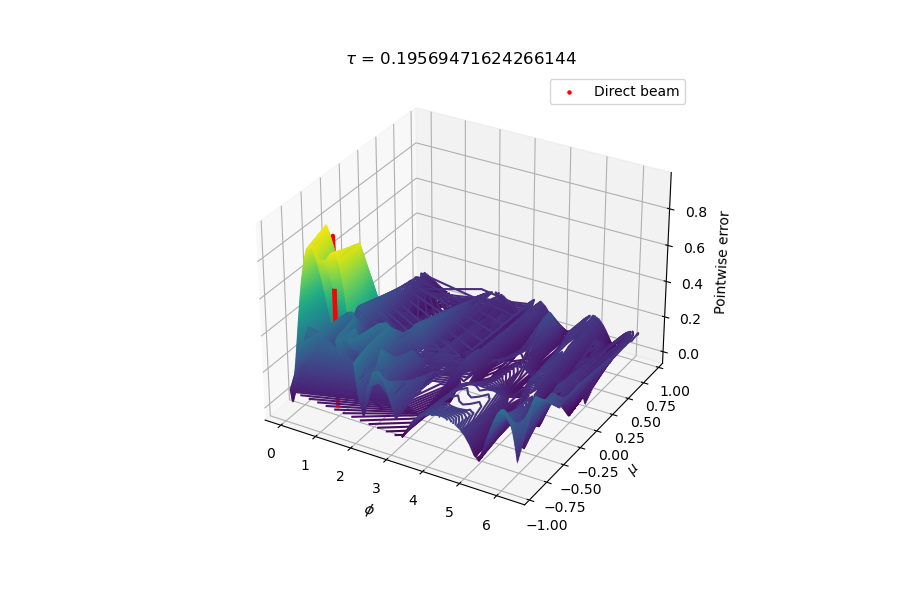

In [75]:
%matplotlib widget
error = np.abs(RHS - LHS)[:, 1, :]

fig = plt.figure(figsize=(9, 6))
ax = plt.axes(projection="3d")
ax.contour3D(MU_ARR, PHI_ARR, error, 200)
ax.scatter(
    phi0,
    -mu0,
    np.linspace(0, np.max(error), 200),
    marker=".",
    color="red",
    label="Direct beam",
)
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\mu$")
ax.set_zlabel("Pointwise error")
plt.title(r"$\tau$ = " + str(tau_arr[1]))
errlim = ax.get_zlim()
plt.legend()

### 3.7.2 Nakajima-Tanaka (NT) corrections (TODO)

This subsection summarizes the main points from [[8]](#cite-NT1988) and omits most of the mathematical explanation. Recall that $\tau^*, \omega^*_0, p^*$ denote $\delta-M$ scaled parameters and $f$ is the scattering fraction. `PyDISORT` requires the true phase function with vector arguments $\mu, \phi, \mu', \phi'$ and hyperparameter $g$ to perform NT corrections. The true phase function must be supplied through the first element of the tuple variable `p_for_NT_with_g`; the second element of `p_for_NT_with_g` supplies the asymmetry factor $g$. The flag to enable NT corrections is `callable(p_for_NT_with_g[0]) == True`.

The $\delta-M$ method allows for accurate flux computation, but intensity values remain inaccurate particularly at very small or very large scattering angles with respect to the direct beam. This is caused by the truncation of the Legendre series of the phase function. Nakajima and Tanaka use perturbation theory to reduce the truncation error. This correction is applied to the intensity but not to the flux as the latter is already accurate. This unfortunately means that flux values calculated by integrating the intensity will differ slightly from values given by the flux functions.

We denote the radiative transfer equation with a general source function $J$,

$$
\mu \frac{\partial u(\tau, \mu, \phi)}{\partial \tau} = u(\tau, \mu, \phi) -\frac{\omega_0}{4 \pi} \int_{-1}^{1} \int_{0}^{2 \pi} p\left(\mu, \phi ; \mu', \phi'\right) u\left(\tau, \mu', \phi'\right) \mathrm{d} \phi' \mathrm{d} \mu' - J
$$

by the functional notation $\mathcal{F}(u, \tau, \omega_0, p; J)$. For example, the original radiative transfer is denoted

$$\mathcal{F}\left(u, \tau, \omega_0, p; \frac{\omega_0 I_0}{4 \pi} p\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right) \exp\left(-\mu_{0}^{-1} \tau\right)\right)$$

using this notation. The NT correction method can be considered an extension of the $\delta-M$ method. For the $\delta-M$ method, we approximate $u_\text{true} \approx u^*$
where $u_\text{true}$ is the true solution to the original radiative transfer equation, and $u^*$ is the true solution to 

$$\mathcal{F}\left(u^*, \tau^*, \omega^*_0, p^*; \frac{\omega^*_0 I_0}{4 \pi} p^*\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right) \exp\left(-\mu_{0}^{-1} \tau^*\right)\right)$$

We can only determine $u^*$ up to some numerical error. This numerical error comes from the eigenvalue solver, quadrature, linear system solver and so on, but does not come from truncation. There is no truncation since $p^*$ is defined as a truncated phase function and we use every term.

For the first of two NT corrections, named *TMS*, we approximate $u_\text{true} \approx u_\text{TMS} := u^* - u_1^* + \tilde{u}_1^*$, where $u_1^*$ and $\tilde{u}_1^*$ are true solutions to the single-scattering equations

$$\mathcal{F}\left(u_1^*, \tau^*, 0, 0; \frac{\omega^*_0 I_0}{4 \pi} p^*\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right) \exp\left(-\mu_{0}^{-1} \tau^*\right)\right), \quad \mathcal{F}\left(\tilde{u}_1^*, \tau^*, 0, 0; \frac{\omega^*_0 I_0}{(1 - f) 4 \pi} p\left(\mu, \phi ;-\mu_{0}, \phi_{0}\right) \exp\left(-\mu_{0}^{-1} \tau^*\right)\right)$$

respectively. By the principle of superposition, every correction term, i.e. every term but $u^*$, must satisfy homogeneous BCs. We can solve for $u_1^*$ and $\tilde{u}_1^*$ analytically:

$$
\begin{aligned}
u_1^*(\tau^*, \mu_i, \phi) &= \mathcal{B}(\tau^*, \mu_i, \phi)\left[\exp\left(-\frac{\tau^*}{\mu_0}\right) - \exp\left(\frac{\tau^* - \tau^*_0}{\mu_i} - \frac{\tau^*_0}{\mu_0}\right)\right] \\
u_1^*(\tau^*, -\mu_i, \phi) &= \mathcal{B}(\tau^*, -\mu_i, \phi)\left[\exp\left(-\frac{\tau^*}{\mu_0}\right) - \exp\left(-\frac{\tau^*}{\mu_i}\right)\right] \\
\end{aligned}
$$

and $\tilde{u}_1^*(\tau^*, \pm\mu_i, \phi)$ are identical except with $\mathcal{B}$ swapped for $\tilde{\mathcal{B}}$. The source terms give

$$
\begin{aligned}
\mathcal{B}(\tau^*, \pm\mu_i, \phi) &= \left(\pm \frac{\mu_i}{\mu_0} + 1 \right)^{-1} \frac{\omega^*_0 I_0}{4 \pi} p^*\left(\pm\mu_i, \phi ;-\mu_{0}, \phi_{0}\right) \exp\left(-\mu_{0}^{-1} \tau^*\right) \\
\tilde{\mathcal{B}}(\tau^*, \pm\mu_i, \phi) &= \left(\pm \frac{\mu_i}{\mu_0} + 1 \right)^{-1} \frac{\omega^*_0 I_0}{(1 - f) 4 \pi} p\left(\pm\mu_i, \phi ;-\mu_{0}, \phi_{0}\right)
\end{aligned}
$$

The TMS correction substantially reduces the truncation error for all angles except those close to the direct beam. Thus, a second NT correction, named *IMS*, is required. For the IMS, we claim that $u_\text{true} \approx u_\text{TMS} + u_\text{IMS}$ where $u_\text{IMS}$ is the true solution to

$$\mathcal{F}\left(u_\text{IMS}, \tau, \omega, p; -J_1 - J_2 - J_3\right)$$

where

\begin{aligned}
J_1 &= \\
J_2 &= \\
J_3 &=
\end{aligned}

*TODO: Complete description of IMS. Also derive analytic solutions where possible*

### 3.7.3 Verification of NT corrected full solution

In [55]:
mu_arr, u_NT, flux_up_NT, flux_down_NT = PyDISORT(
    b_pos, b_neg,
    False,
    NQuad, tau0, w0,
    Leg_coeffs,
    mu0, phi0, I0,
    f=f,
    p_for_NT_with_g=p_for_NT_with_g,
)

**Does the full solution satisfy the BCs?**

In [56]:
# At top of atmosphere
assert np.allclose(
    u_NT(0, phi_arr)[N:, :],
    b_neg @ np.cos(np.arange(NLeg)[:, None] * (phi0 - phi_arr)[None, :]),
)

# At bottom of atmosphere
assert np.allclose(
    u_NT(tau0, phi_arr)[:N, :],
    b_pos @ np.cos(np.arange(NLeg)[:, None] * (phi0 - phi_arr)[None, :]),
)
print("Passed all tests")

Passed all tests


**Does the full solution satisfy the radiative transfer equation?**

In [57]:
u_NT_cache = u_NT(tau_arr, phi_arr)

In [58]:
LHS_NT = mu_arr[:, None, None] * np.einsum("itp, tj -> ijp", u_NT_cache, first_deriv)
RHS_NT = (
    u_NT_cache
    - (w0 / (4 * pi))
    * np.einsum(
        "ijkl, ktl, k, l -> itj",
        p_HG_muphi(mu_arr, phi_arr, mu_arr, phi_arr, g),
        u_NT_cache,
        full_weights_mu,
        full_weights_phi,
        optimize=True,
    )
    - (w0 * I0 / (4 * pi))
    * p_HG_muphi(mu_arr, phi_arr, -mu0, phi0, g)[:, None, :]
    * np.exp(-tau_arr[None, :, None] / mu0)
)

In [59]:
print("L2 pointwise error =", np.linalg.norm(LHS_NT - RHS_NT))
print("L2 norm error =", np.abs(np.linalg.norm(LHS_NT) - np.linalg.norm(RHS_NT)))

L2 pointwise error = 5.808383989252644
L2 norm error = 0.45712732826143565


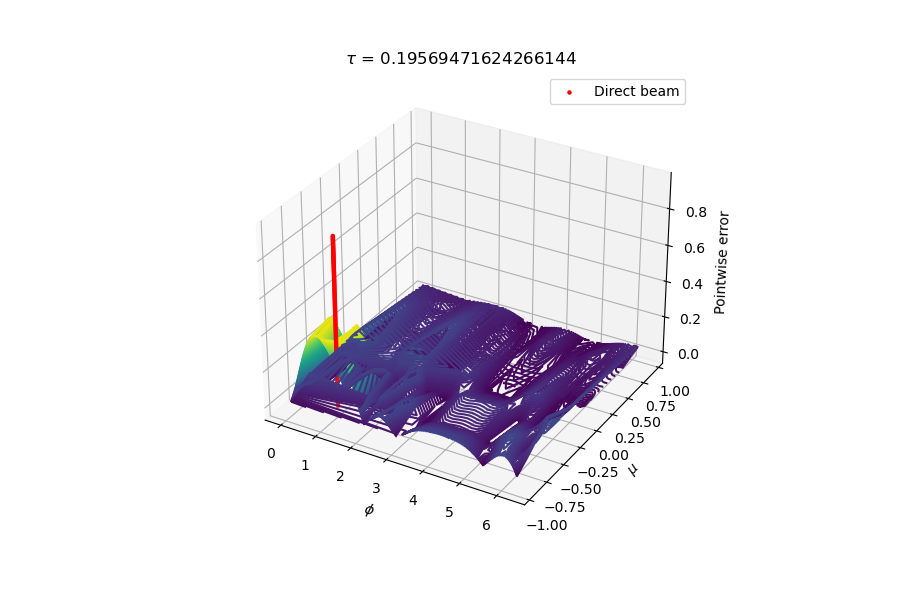

In [76]:
%matplotlib widget
error_NT = np.abs(RHS_NT - LHS_NT)[:, 1, :]

fig = plt.figure(figsize=(9, 6))
ax = plt.axes(projection="3d")
ax.contour3D(MU_ARR, PHI_ARR, error_NT, 200)
ax.scatter(
    phi0,
    -mu0,
    np.linspace(0, np.max(error), 200),
    marker=".",
    color="red",
    label="Direct beam",
)
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\mu$")
ax.set_zlabel("Pointwise error")
ax.set_zlim(errlim)
plt.title(r"$\tau$ = " + str(tau_arr[1]))
plt.legend()

### 3.7.4 Computation of flux

`PyDISORT` also returns the positive and negative (hemispheric) flux functions. We have that

$$
F_\text{total}^\pm(\tau) = F_\text{diffuse}^\pm(\tau) + F_\text{direct}^\pm(\tau)
$$


Since the direct beam is

$$u_\text{direct}(\tau, \mu, \phi) = I_0 \delta(\mu - \mu_0) \delta(\phi - \phi_0) \exp\left(-\mu_{0}^{-1} \tau\right)$$

and $\mu_0 > 0$, we have 

$$F_\text{direct}^+(\tau) \equiv 0, \quad F_\text{direct}^-(\tau) = I_0 \mu_0 \exp\left(-\mu_{0}^{-1} \tau\right)$$

The diffuse flux equals

$$
\begin{aligned}
F_\text{diffuse}^\pm(\tau) &= \int_{0}^{1} \int_{0}^{2 \pi} \mu u\left(\tau, \pm\mu, \phi\right) \mathrm{d} \phi \mathrm{d} \mu \\
& \approx \sum_{m=0} \left(\int_{0}^{1} \mu u^m(\tau, \pm\mu) \mathrm{d} \mu \int_{0}^{2 \pi} \cos\left(m\left(\phi_0 - \phi\right)\right) \mathrm{d} \phi \right) \\
&= 2\pi \int_{0}^{1} \mu u^0\left(\tau, \pm\mu\right) \mathrm{d} \mu \\
&\approx 2\pi \sum_{i = 1} w_i\mu_i u^0\left(\tau, \pm\mu_i\right)
\end{aligned}
$$

where we used the cosine expansion of $u$ from section [3.2](#3.2-Re-derivation-of-equations-%286a%29-to-Re-derivation-of-equations-%286a%29-to-3.2-Re-derivation-of-equations-%286a%29-to-Re-derivation-of-equations-%286a%29-to-3.2-Re-derivation-of-equations-%286a%29-to-Re-derivation-of-equations-%286a%29-to-3.2-Re-derivation-of-equations-%286a%29-to-%286d%29-in-Stamnes-et.-al.,-1988). In the last line we approximated the $\mu$ integral by Gauss-Legendre quadrature. Only the $0$th moment matters for the flux. With $\delta-M$ scaling, we have

$$
F_\text{direct}^-(\tau) \equiv (1 + \omega_0 f) I_0 \mu_0 \exp\left(-\mu_{0}^{-1} \tau\right), \quad F_\text{diffuse}^\pm(\tau^*_0) \approx 2\pi \sum_{i = 1} w_i\mu_i u^{*0}\left(\tau^*_0, \pm\mu_i\right)
$$

instead. Note that $\tau$ has to be mapped to $\tau^*$ before being inputted into $F_\text{diffuse}^\pm$. The upwelling and downwelling equal 

$$F_\text{total}^+(0), \quad F_\text{total}^-(\tau_0)$$ 

respectively.

**IMPORTANT:** reminder that `PyDISORT` will output the **diffuse intensity** and the **total flux**. One will need to separately / manually add the intensity of the direct beam to get the total intensity.

#### 3.7.4.1 Verification of flux

[Skip verification](#3.7.4.2-Computation-of-reflectivity-and-transmittivity)

**Does integrating the intensity functions produce the flux functions?**

This will only be true if
* `callable(p_for_NT_with_g[0]) == False`, because the corrections are applied only to the intensity and not the fluxes
* We manually add the direct flux to `flux_up_test` and `flux_down_test`, since `PyDISORT` only outputs the diffuse, and not total, intensity

In [61]:
flux_up_test = np.einsum(
    "itp, i, p -> t",
    mu_arr_pos[:, None, None] * u_cache[:N, :],
    weights_mu,
    full_weights_phi,
    optimize=True,
)
flux_down_test = np.einsum(
    "itp, i, p -> t",
    mu_arr_pos[:, None, None] * u_cache[N:, :],
    weights_mu,
    full_weights_phi,
    optimize=True,
)
# Add the direct flux and account for delta-M scaling
if np.issubdtype(type(f), np.number):
    flux_down_test += I0 * mu0 * np.exp(-tau_arr / mu0) 
else:
    flux_down_test += (1 + w0 * f) * I0 * mu0 * np.exp(-tau_arr / mu0)
    

assert np.allclose(flux_up_test, flux_up(tau_arr))
assert np.allclose(flux_down_test, flux_down(tau_arr))
print("Passed all tests")

Passed all tests


#### 3.7.4.2 Computation of reflectivity and transmittivity

In order to compute the reflectivity and transmittivity, we first need to determine the incident flux. The incident flux from the direct beam is $I_0 \mu_0 \exp\left(-\mu_{0}^{-1} \tau\right)$ or $(1 + \omega_0 f) I_0 \mu_0 \exp\left(-\mu_{0}^{-1} \tau\right)$ if $\delta-M$ scaling is enabled. Recall that the boundary conditions are

$$
u\left(\tau_0, \mu_i, \phi \right) = \sum_{m = 0}^{\text{NLeg}}b^+_{im}\cos(m(\phi_0 - \phi)), \quad u(0, -\mu_i, \phi) = \sum_{m = 0}^{\text{NLeg}}b^-_{im}\cos(m(\phi_0 - \phi)) \quad i = 1, \dots, N
$$

The incident flux from the BCs, which we denote $F_{b^\pm}$, are

$$F_{b^\pm} = 2 \pi \sum_{i = 0}^N w_i \mu_i b^\pm_{i0}$$

respectively, where $w_i$ are the Gauss-Legendre weights.  Once again, only the $0$th moment matters for the flux. If the BCs are constant over $\mu$, we will have 

$$F_{b^\pm} = \pi b^\pm$$

instead.

Reflectivity, $R$, and transmittivity, $T$, calculations only make sense if the incident radiation comes entirely from one side of the atmosphere, usually downwards onto the top layer. In addition, we generally want to calculate reflectivity and transmittivity with respect to a specific source. As an example, we calculate the reflectivity and transmittivity with respect to the direct beam:

$$R = \frac{F_\text{Total}^+(0)}{I_0 \mu_0}, \quad T = \frac{F_\text{Total}^-(\tau_0)}{I_0 \mu_0}$$

which requires the BCs, $b^\pm = 0$.

In [62]:
flux_up, flux_down = PyDISORT(0, 0, True, NQuad, tau0, w0, Leg_coeffs, mu0, phi0, I0)[1:3]


print("Reflectivity, R =", flux_up(0) / (I0 * mu0))
print("Transmittivity, T =", flux_down(tau0) / (I0 * mu0))

Reflectivity, R = 0.006776042277710097
Transmittivity, T = 2.400675911299744e-42


### 3.7.5 Timing PyDISORT

[Skip section](#4.-Solving-for-multiple-atmospheric-layers-%28TODO%29)

The time taken will of course be parameter-dependent, but this should give a sense of the speed of `PyDISORT`.

In [63]:
# Values of parameters that affect the speed of PyDISORT the most
print("NLeg, NQuad, Ntau, Nphi =", NLeg, NQuad, Ntau, Nphi)

NLeg, NQuad, Ntau, Nphi = 8 8 512 65


**Time taken to solve the radiative transfer equation**

In [64]:
# For intensity
%timeit PyDISORT(b_pos, b_neg, False, NQuad, tau0, w0, Leg_coeffs, mu0, phi0, I0)

# For flux
%timeit PyDISORT(b_pos, b_neg, True, NQuad, tau0, w0, Leg_coeffs, mu0, phi0, I0)

5.2 ms ± 298 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.25 ms ± 30.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


**Time taken to evaluate the solution at a point**

In [65]:
# For intensity
%timeit u(tau_arr[Ntau//2], phi_arr[Nphi//2])

# For flux
%timeit flux_up(0)
%timeit flux_down(tau0)

347 µs ± 23.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
58.1 µs ± 2.07 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
66.3 µs ± 3.91 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# 4. Solving for multiple atmospheric layers (TODO)

*TODO: Discuss $R_{\text{sys}}$, Lambertian surface and even BDRF for a multi-layer system?*

# 5. Comparisons with Stamnes' DISORT (TODO)

[[2]](#cite-Sta1999)

<!--bibtex

@article{NT1988,
title = {Algorithms for radiative intensity calculations in moderately thick atmospheres using a truncation approximation},
journal = {Journal of Quantitative Spectroscopy and Radiative Transfer},
volume = {40},
number = {1},
pages = {51-69},
year = {1988},
issn = {0022-4073},
doi = {https://doi.org/10.1016/0022-4073(88)90031-3},
url = {https://www.sciencedirect.com/science/article/pii/0022407388900313},
author = {T. Nakajima and M. Tanaka},
abstract = {The efficiency of numerical calculations is discussed for selected algorithms employing the discrete ordinate method and the truncation approximation for the solar radiative intensity in moderately thick, plane-parallel scattering atmospheres. It is found that truncation of the phase function causes a significant error in the computed intensity and the magnitude of this error depends significantly on how the intensity is retrieved from the truncated radiative transfer equation. A newly developed retrieval algorithm, the IMS- method, yields the intensity field with an error ⪅1% when the number of discrete path is as small as 10 in the hemisphere for aerosol-laden atmospheres with optical thickness ⪅1.}
}

@article{YTA1971,
title = {Radiative heat transfer in water clouds by infrared radiation},
journal = {Journal of Quantitative Spectroscopy and Radiative Transfer},
volume = {11},
number = {6},
pages = {697-708},
year = {1971},
issn = {0022-4073},
doi = {https://doi.org/10.1016/0022-4073(71)90048-3},
url = {https://www.sciencedirect.com/science/article/pii/0022407371900483},
author = {Giichi Yamamoto and Masayuki Tanaka and Shoji Asano},
abstract = {Radiative heat transfer in water clouds is studied by the method of discrete ordinates, taking into account not only scattering, absorption and emission by cloud droplets but also absorption and emission by water vapor in the cloud. According to Semuelson the method of discrete ordinates is not very amenable to studies involving the intermediate optical thickness, because of instabilities that are inherent in the method for the intermediate optical thickness. A method of avoiding these instabilities is shown in this paper. Numerical calculation for the spectral region from 5 to 40 μ was carried out on the model altostratus clouds, and that only for the window region on the model stratocumulus and nimbostratus clouds. The radiative temperature change in a very thin cloud is everywhere cooling. With increasing cloud thickness, however, the upper parts of the cloud undergo cooling, while the lower parts undergo heating. The rate of both heating and cooling is largest near the surface. In a semi-infinitely thick cloud the cloud top undergoes cooling at a rate of about 30°C/hr and effective cooling extends to about 100 m interior from the cloud boundary.}
}

@book{Cha1960, 
      author = "S.  Chandrasekhar",
      title = "Radiative Transfer",
      year = "1960",
      publisher = "Dover",
}

@article{Wis1977,
      author = "W. J.  Wiscombe",
      title = "The Delta–M Method: Rapid Yet Accurate Radiative Flux Calculations for Strongly Asymmetric Phase Functions",
      journal = "Journal of Atmospheric Sciences",
      year = "1977",
      publisher = "American Meteorological Society",
      address = "Boston MA, USA",
      volume = "34",
      number = "9",
      doi = "10.1175/1520-0469(1977)034<1408:TDMRYA>2.0.CO;2",
      pages=      "1408 - 1422",
      url = "https://journals.ametsoc.org/view/journals/atsc/34/9/1520-0469_1977_034_1408_tdmrya_2_0_co_2.xml"
}

@article{Syk1951,
    author = {Sykes, J. B.},
    title = "{Approximate Integration of the Equation of Transfer}",
    journal = {Monthly Notices of the Royal Astronomical Society},
    volume = {111},
    number = {4},
    pages = {377-386},
    year = {1951},
    month = {08},
    abstract = "{The value of numerical integration in obtaining approximate solutions of an equation of transfer, and the different methods at our disposal, are discussed. It is shown that although the Newton-Cotes method, used by Kourganoff, is better than the Gauss method, used by Chandrasekhar, both are inferior to a new method, the double-Gauss, discovered by the author. The errors in the approximate values of the source-function and the limb-darkening in all three methods are tabulated for various approximations, and illustrated by graphs.}",
    issn = {0035-8711},
    doi = {10.1093/mnras/111.4.377},
    url = {https://doi.org/10.1093/mnras/111.4.377},
    eprint = {https://academic.oup.com/mnras/article-pdf/111/4/377/8077435/mnras111-0377.pdf},
}


@article{STWJ1988,
author = {Knut Stamnes and S-Chee Tsay and Warren Wiscombe and Kolf Jayaweera},
journal = {Appl. Opt.},
keywords = {Electromagnetic radiation; Multiple scattering; Optical depth; Radiative transfer; Reflection; Thermal emission},
number = {12},
pages = {2502--2509},
publisher = {Optica Publishing Group},
title = {Numerically stable algorithm for discrete-ordinate-method radiative transfer in multiple scattering and emitting layered media},
volume = {27},
month = {Jun},
year = {1988},
url = {http://opg.optica.org/ao/abstract.cfm?URI=ao-27-12-2502},
doi = {10.1364/AO.27.002502},
abstract = {We summarize an advanced, thoroughly documented, and quite general purpose discrete ordinate algorithm for time-independent transfer calculations in vertically inhomogeneous, nonisothermal, plane-parallel media. Atmospheric applications ranging from the UV to the radar region of the electromagnetic spectrum are possible. The physical processes included are thermal emission, scattering, absorption, and bidirectional reflection and emissionat the lower boundary. The medium may be forced at the top boundary by parallel or diffuse radiation and by internal and boundary thermal sources as well. We provide a brief account of the theoretical basis as well as a discussion of the numerical implementation of the theory. The recent advances made by ourselves and our collaborators---advances in both formulation and numerical solution---are all incorporated in the algorithm. Prominent among these advances are the complete conquest of two ill-conditioning problems which afflicted all previous discrete ordinate implementations: (1) the computation of eigenvalues and eigenvectors and (2) the inversion of the matrix determining the constants of integration. Copies of the fortran program on microcomputer diskettes are available for interested users.},
}



@article{STL2000,
author = {Stamnes, Knut and Tsay, Si-Chee and Wiscombe, Warren and Laszlo, Istvan and Einaudi, Franco},
year = {2000},
month = {02},
pages = {},
title = {General Purpose Fortran Program for Discrete-Ordinate-Method Radiative Transfer in Scattering and Emitting Layered Media: An Update of DISORT}
}

@article{SS1981,
      author = "Knut  Stamnes and Roy A.  Swanson",
      title = "A New Look at the Discrete Ordinate Method for Radiative Transfer Calculations in Anisotropically Scattering Atmospheres",
      journal = "Journal of Atmospheric Sciences",
      year = "1981",
      publisher = "American Meteorological Society",
      address = "Boston MA, USA",
      volume = "38",
      number = "2",
      doi = "10.1175/1520-0469(1981)038<0387:ANLATD>2.0.CO;2",
      pages=      "387 - 399",
      url = "https://journals.ametsoc.org/view/journals/atsc/38/2/1520-0469_1981_038_0387_anlatd_2_0_co_2.xml"
}

@article{SC1984,
title = {A new multi-layer discrete ordinate approach to radiative transfer in vertically inhomogeneous atmospheres},
journal = {Journal of Quantitative Spectroscopy and Radiative Transfer},
volume = {31},
number = {3},
pages = {273-282},
year = {1984},
issn = {0022-4073},
doi = {https://doi.org/10.1016/0022-4073(84)90031-1},
url = {https://www.sciencedirect.com/science/article/pii/0022407384900311},
author = {Knut Stamnes and Paul Conklin},
abstract = {A recently developed matrix formulation of the discrete ordinate method is extended for application to an inhomogeneous atmosphere. The solution yields fluxes, as well as the complete azimuthal dependence of the intensity at any level in the atmosphere. The numerical aspects of the solution are discussed and numerical verification is provided by comparing computed results with those obtained by other methods. In particular, it is shown that a simple scaling scheme, which removes the positive exponentials in the coefficient matrix when solving for the constants of integration, provides unconditionally stable solutions for arbitrary optical thicknesses. An assessment of the accuracy to be expected is also provided, and it is shown that low-order discrete ordinate approximations yield very accurate flux values.}
}

@article{MH2017,
title = {A demonstration of adjoint methods for multi-dimensional remote sensing of the atmosphere and surface},
journal = {Journal of Quantitative Spectroscopy and Radiative Transfer},
volume = {204},
pages = {215-231},
year = {2018},
issn = {0022-4073},
doi = {https://doi.org/10.1016/j.jqsrt.2017.09.031},
url = {https://www.sciencedirect.com/science/article/pii/S0022407317305198},
author = {William G.K. Martin and Otto P. Hasekamp},
keywords = {Adjoint methods, Three-dimensional vector radiative transfer, Linearization, Remote sensing, Parameter derivatives, Searchlight functions},
abstract = {In previous work, we derived the adjoint method as a computationally efficient path to three-dimensional (3D) retrievals of clouds and aerosols. In this paper we will demonstrate the use of adjoint methods for retrieving two-dimensional (2D) fields of cloud extinction. The demonstration uses a new 2D radiative transfer solver (FSDOM). This radiation code was augmented with adjoint methods to allow efficient derivative calculations needed to retrieve cloud and surface properties from multi-angle reflectance measurements. The code was then used in three synthetic retrieval studies. Our retrieval algorithm adjusts the cloud extinction field and surface albedo to minimize the measurement misfit function with a gradient-based, quasi-Newton approach. At each step we compute the value of the misfit function and its gradient with two calls to the solver FSDOM. First we solve the forward radiative transfer equation to compute the residual misfit with measurements, and second we solve the adjoint radiative transfer equation to compute the gradient of the misfit function with respect to all unknowns. The synthetic retrieval studies verify that adjoint methods are scalable to retrieval problems with many measurements and unknowns. We can retrieve the vertically-integrated optical depth of moderately thick clouds as a function of the horizontal coordinate. It is also possible to retrieve the vertical profile of clouds that are separated by clear regions. The vertical profile retrievals improve for smaller cloud fractions. This leads to the conclusion that cloud edges actually increase the amount of information that is available for retrieving the vertical profile of clouds. However, to exploit this information one must retrieve the horizontally heterogeneous cloud properties with a 2D (or 3D) model. This prototype shows that adjoint methods can efficiently compute the gradient of the misfit function. This work paves the way for the application of similar methods to 3D remote sensing problems.}
}

@article{MCB2014,
title = {Adjoint methods for adjusting three-dimensional atmosphere and surface properties to fit multi-angle/multi-pixel polarimetric measurements},
journal = {Journal of Quantitative Spectroscopy and Radiative Transfer},
volume = {144},
pages = {68-85},
year = {2014},
issn = {0022-4073},
doi = {https://doi.org/10.1016/j.jqsrt.2014.03.030},
url = {https://www.sciencedirect.com/science/article/pii/S002240731400154X},
author = {William Martin and Brian Cairns and Guillaume Bal},
keywords = {Adjoint methods, Three-dimensional vector radiative transfer, Linearization, Remote sensing, Parameter derivatives},
abstract = {This paper derives an efficient procedure for using the three-dimensional (3D) vector radiative transfer equation (VRTE) to adjust atmosphere and surface properties and improve their fit with multi-angle/multi-pixel radiometric and polarimetric measurements of scattered sunlight. The proposed adjoint method uses the 3D VRTE to compute the measurement misfit function and the adjoint 3D VRTE to compute its gradient with respect to all unknown parameters. In the remote sensing problems of interest, the scalar-valued misfit function quantifies agreement with data as a function of atmosphere and surface properties, and its gradient guides the search through this parameter space. Remote sensing of the atmosphere and surface in a three-dimensional region may require thousands of unknown parameters and millions of data points. Many approaches would require calls to the 3D VRTE solver in proportion to the number of unknown parameters or measurements. To avoid this issue of scale, we focus on computing the gradient of the misfit function as an alternative to the Jacobian of the measurement operator. The resulting adjoint method provides a way to adjust 3D atmosphere and surface properties with only two calls to the 3D VRTE solver for each spectral channel, regardless of the number of retrieval parameters, measurement view angles or pixels. This gives a procedure for adjusting atmosphere and surface parameters that will scale to the large problems of 3D remote sensing. For certain types of multi-angle/multi-pixel polarimetric measurements, this encourages the development of a new class of three-dimensional retrieval algorithms with more flexible parametrizations of spatial heterogeneity, less reliance on data screening procedures, and improved coverage in terms of the resolved physical processes in the Earth׳s atmosphere.}
}

@article{LSJLTWS2015,
title = {Improved discrete ordinate solutions in the presence of an anisotropically reflecting lower boundary: Upgrades of the DISORT computational tool},
journal = {Journal of Quantitative Spectroscopy and Radiative Transfer},
volume = {157},
pages = {119-134},
year = {2015},
issn = {0022-4073},
doi = {https://doi.org/10.1016/j.jqsrt.2015.02.014},
url = {https://www.sciencedirect.com/science/article/pii/S0022407315000679},
author = {Z. Lin and S. Stamnes and Z. Jin and I. Laszlo and S.-C. Tsay and W.J. Wiscombe and K. Stamnes},
keywords = {Radiative transfer model, BRDF, Cox–Munk, Ross–Li, RPV, Single scattering correction},
abstract = {A successor version 3 of DISORT (DISORT3) is presented with important upgrades that improve the accuracy, efficiency, and stability of the algorithm. Compared with version 2 (DISORT2 released in 2000) these upgrades include (a) a redesigned BRDF computation that improves both speed and accuracy, (b) a revised treatment of the single scattering correction, and (c) additional efficiency and stability upgrades for beam sources. In DISORT3 the BRDF computation is improved in the following three ways: (i) the Fourier decomposition is prepared “off-line”, thus avoiding the repeated internal computations done in DISORT2; (ii) a large enough number of terms in the Fourier expansion of the BRDF is employed to guarantee accurate values of the expansion coefficients (default is 200 instead of 50 in DISORT2); (iii) in the post-processing step the reflection of the direct attenuated beam from the lower boundary is included resulting in a more accurate single scattering correction. These improvements in the treatment of the BRDF have led to improved accuracy and a several-fold increase in speed. In addition, the stability of beam sources has been improved by removing a singularity occurring when the cosine of the incident beam angle is too close to the reciprocal of any of the eigenvalues. The efficiency for beam sources has been further improved from reducing by a factor of 2 (compared to DISORT2) the dimension of the linear system of equations that must be solved to obtain the particular solutions, and by replacing the LINPAK routines used in DISORT2 by LAPACK 3.5 in DISORT3. These beam source stability and efficiency upgrades bring enhanced stability and an additional 5–7% improvement in speed. Numerical results are provided to demonstrate and quantify the improvements in accuracy and efficiency of DISORT3 compared to DISORT2.}
}

@article {JWW1976,
      author = "J. H.  Joseph and W. J.  Wiscombe and J. A.  Weinman",
      title = "The Delta-Eddington Approximation for Radiative Flux Transfer",
      journal = "Journal of Atmospheric Sciences",
      year = "1976",
      publisher = "American Meteorological Society",
      address = "Boston MA, USA",
      volume = "33",
      number = "12",
      doi = "10.1175/1520-0469(1976)033<2452:TDEAFR>2.0.CO;2",
      pages=      "2452 - 2459",
      url = "https://journals.ametsoc.org/view/journals/atsc/33/12/1520-0469_1976_033_2452_tdeafr_2_0_co_2.xml"
}

@Article{HMMNPW2017,
AUTHOR = {Hase, N. and Miller, S. M. and Maa{\ss}, P. and Notholt, J. and Palm, M. and Warneke, T.},
TITLE = {Atmospheric inverse modeling via sparse reconstruction},
JOURNAL = {Geoscientific Model Development},
VOLUME = {10},
YEAR = {2017},
NUMBER = {10},
PAGES = {3695--3713},
URL = {https://gmd.copernicus.org/articles/10/3695/2017/},
DOI = {10.5194/gmd-10-3695-2017}
}

@article {FL1992,
      author = "Qiang  Fu and K. N.  Liou",
      title = "On the Correlated k-Distribution Method for Radiative Transfer in Nonhomogeneous Atmospheres",
      journal = "Journal of Atmospheric Sciences",
      year = "1992",
      publisher = "American Meteorological Society",
      address = "Boston MA, USA",
      volume = "49",
      number = "22",
      doi = "10.1175/1520-0469(1992)049<2139:OTCDMF>2.0.CO;2",
      pages=      "2139 - 2156",
      url = "https://journals.ametsoc.org/view/journals/atsc/49/22/1520-0469_1992_049_2139_otcdmf_2_0_co_2.xml"
}

@inproceedings{FJ1999,
  title={Computer-based underwater imaging analysis},
  author={Georges R. Fournier and Miroslaw Jonasz},
  booktitle={Optics \& Photonics},
  year={1999}
}

@article{DM2010,
	doi = {10.1088/0034-4885/73/2/026801},
	url = {https://doi.org/10.1088/0034-4885/73/2/026801},
	year = 2010,
	month = {jan},
	publisher = {{IOP} Publishing},
	volume = {73},
	number = {2},
	pages = {026801},
	author = {Anthony B Davis and Alexander Marshak},
	title = {Solar radiation transport in the cloudy atmosphere: a 3D perspective on observations and climate impacts},
	journal = {Reports on Progress in Physics},
	abstract = {The interplay of sunlight with clouds is a ubiquitous and often pleasant visual experience, but it conjures up major challenges for weather, climate, environmental science and beyond. Those engaged in the characterization of clouds (and the clear air nearby) by remote sensing methods are even more confronted. The problem comes, on the one hand, from the spatial complexity of real clouds and, on the other hand, from the dominance of multiple scattering in the radiation transport. The former ingredient contrasts sharply with the still popular representation of clouds as homogeneous plane-parallel slabs for the purposes of radiative transfer computations. In typical cloud scenes the opposite asymptotic transport regimes of diffusion and ballistic propagation coexist. We survey the three-dimensional (3D) atmospheric radiative transfer literature over the past 50 years and identify three concurrent and intertwining thrusts: first, how to assess the damage (bias) caused by 3D effects in the operational 1D radiative transfer models? Second, how to mitigate this damage? Finally, can we exploit 3D radiative transfer phenomena to innovate observation methods and technologies? We quickly realize that the smallest scale resolved computationally or observationally may be artificial but is nonetheless a key quantity that separates the 3D radiative transfer solutions into two broad and complementary classes: stochastic and deterministic. Both approaches draw on classic and contemporary statistical, mathematical and computational physics.}
}

@article{DFDM2021,
      author = "Linda Forster and Anthony B. Davis and David J. Diner and Bernhard Mayer",
      title = "Toward Cloud Tomography from Space Using MISR and MODIS: Locating the “Veiled Core” in Opaque Convective Clouds",
      journal = "Journal of the Atmospheric Sciences",
      year = "2021",
      publisher = "American Meteorological Society",
      address = "Boston MA, USA",
      volume = "78",
      number = "1",
      doi = "10.1175/JAS-D-19-0262.1",
      pages=      "155 - 166",
      url = "https://journals.ametsoc.org/view/journals/atsc/78/1/jas-d-19-0262.1.xml"
}

@article{DDET2022,
title = {Cloud tomographic retrieval algorithms. I: Surrogate minimization method},
journal = {Journal of Quantitative Spectroscopy and Radiative Transfer},
volume = {277},
pages = {107954},
year = {2022},
issn = {0022-4073},
doi = {https://doi.org/10.1016/j.jqsrt.2021.107954},
url = {https://www.sciencedirect.com/science/article/pii/S0022407321004465},
author = {Adrian Doicu and Alexandru Doicu and Dmitry Efremenko and Thomas Trautmann},
keywords = {Cloud tomographic retrieval, Multi-dimensional models},
abstract = {A cloud tomographic retrieval algorithm relying on (i) the spherical harmonics discrete ordinate method for computing the radiative transfer and (ii) the surrogate minimization method for solving the inverse problem has been designed. The retrieval algorithm uses regularization, accelerated projected gradient methods, and two types of surrogate functions. The performances of the retrieval algorithm are analyzed on a few synthetic two- and three-dimensional problems.}
}

@misc{Sta1999, 
	title={LLLab disort website}, 
	url={http://www.rtatmocn.com/disort/}, 
	journal={Light and Life Lab (LLLab)}, 
	author={Stamnes, S.}, 
	year={1999}
} 

@INPROCEEDINGS{ALHSAV2020,
  author={Aides, Amit and Levis, Aviad and Holodovsky, Vadim and Schechner, Yoav Y. and Althausen, Dietrich and Vainiger, Adi},
  booktitle={2020 IEEE International Conference on Computational Photography (ICCP)}, 
  title={Distributed Sky Imaging Radiometry and Tomography}, 
  year={2020},
  volume={},
  number={},
  pages={1-12},
  doi={10.1109/ICCP48838.2020.9105241}}

@article {MW1980,
      author = "W. E.  Meador and W. R.  Weaver",
      title = "Two-Stream Approximations to Radiative Transfer in Planetary Atmospheres: A Unified Description of Existing Methods and a New Improvement",
      journal = "Journal of Atmospheric Sciences",
      year = "1980",
      publisher = "American Meteorological Society",
      address = "Boston MA, USA",
      volume = "37",
      number = "3",
      doi = "10.1175/1520-0469(1980)037<0630:TSATRT>2.0.CO;2",
      pages=      "630 - 643",
      url = "https://journals.ametsoc.org/view/journals/atsc/37/3/1520-0469_1980_037_0630_tsatrt_2_0_co_2.xml"
}


-->

# References

<a id="cite-STWJ1988"/><sup><a href=#ref-1>[^]</a><a href=#ref-4>[^]</a><a href=#ref-6>[^]</a><a href=#ref-8>[^]</a><a href=#ref-13>[^]</a><a href=#ref-14>[^]</a><a href=#ref-16>[^]</a><a href=#ref-18>[^]</a></sup>Knut Stamnes and S-Chee Tsay and Warren Wiscombe and Kolf Jayaweera. 1988. _Numerically stable algorithm for discrete-ordinate-method radiative transfer in multiple scattering and emitting layered media_. [URL](http://opg.optica.org/ao/abstract.cfm?URI=ao-27-12-2502)

<a id="cite-Sta1999"/><sup><a href=#ref-2>[^]</a><a href=#ref-5>[^]</a><a href=#ref-7>[^]</a><a href=#ref-21>[^]</a></sup>Stamnes, S.. 1999. _LLLab disort website_. [URL](http://www.rtatmocn.com/disort/)

<a id="cite-SC1984"/><sup><a href=#ref-3>[^]</a><a href=#ref-11>[^]</a><a href=#ref-19>[^]</a></sup>Knut Stamnes and Paul Conklin. 1984. _A new multi-layer discrete ordinate approach to radiative transfer in vertically inhomogeneous atmospheres_. [URL](https://www.sciencedirect.com/science/article/pii/0022407384900311)

<a id="cite-Wis1977"/><sup><a href=#ref-9>[^]</a><a href=#ref-15>[^]</a></sup>W. J.  Wiscombe. 1977. _The Delta–M Method: Rapid Yet Accurate Radiative Flux Calculations for Strongly Asymmetric Phase Functions_. [URL](https://journals.ametsoc.org/view/journals/atsc/34/9/1520-0469_1977_034_1408_tdmrya_2_0_co_2.xml)

<a id="cite-JWW1976"/><sup><a href=#ref-10>[^]</a></sup>J. H.  Joseph and W. J.  Wiscombe and J. A.  Weinman. 1976. _The Delta-Eddington Approximation for Radiative Flux Transfer_. [URL](https://journals.ametsoc.org/view/journals/atsc/33/12/1520-0469_1976_033_2452_tdeafr_2_0_co_2.xml)

<a id="cite-MW1980"/><sup><a href=#ref-12>[^]</a></sup>W. E.  Meador and W. R.  Weaver. 1980. _Two-Stream Approximations to Radiative Transfer in Planetary Atmospheres: A Unified Description of Existing Methods and a New Improvement_. [URL](https://journals.ametsoc.org/view/journals/atsc/37/3/1520-0469_1980_037_0630_tsatrt_2_0_co_2.xml)

<a id="cite-Syk1951"/><sup><a href=#ref-17>[^]</a></sup>Sykes, J. B.. 1951. _Approximate Integration of the Equation of Transfer_. [URL](https://doi.org/10.1093/mnras/111.4.377)

<a id="cite-NT1988"/><sup><a href=#ref-20>[^]</a></sup>T. Nakajima and M. Tanaka. 1988. _Algorithms for radiative intensity calculations in moderately thick atmospheres using a truncation approximation_. [URL](https://www.sciencedirect.com/science/article/pii/0022407388900313)

